In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
def read_json_to_dataframe(file_path):
    return pd.read_json(file_path)

# Example usage
set1_human = read_json_to_dataframe('/content/drive/MyDrive/Colab Notebooks/set1_human.json')
set1_machine = read_json_to_dataframe('/content/drive/MyDrive/Colab Notebooks/set1_machine.json')
set2_human = read_json_to_dataframe('/content/drive/MyDrive/Colab Notebooks/set2_human.json')
set2_machine = read_json_to_dataframe('/content/drive/MyDrive/Colab Notebooks/set2_machine.json')
predict_x = read_json_to_dataframe('/content/drive/MyDrive/Colab Notebooks/test.json')

In [ ]:
import torch
class config :
    max_len_concat = 500
    batch_size = 256 # 64 16 28 128 32
    pretrain_learning_rate = 1e-5 # -5 -3
    vocab_size = 5000
    embedding_dim = 1024
    input_size = max_len_concat
    hidden_size = 256
    num_epochs = 100 # 1 2 !# 5....
    fine_tune_learning_rate = 2e-8
    num_machine = 6

In [ ]:
def combine_lists(row):
    return row['prompt'] +[1]+ row['txt']
def combine_datasets(set1_human, set1_machine, set2_human, set2_machine):
    # Add labels to the DataFrames

    set1_human['machine_id'] = 5
    set2_human['machine_id'] = 5

    # Combine the DataFrames
    set1_dataset = pd.concat([set1_human, set1_machine], ignore_index=True)
    set2_dataset = pd.concat([set2_human, set2_machine], ignore_index=True)
    # Shuffle the combined dataset
    set1_dataset = set1_dataset.sample(frac=1).reset_index(drop=True)
    set2_dataset = set2_dataset.sample(frac=1).reset_index(drop=True)
    set1_dataset['concat'] = set1_dataset.apply(lambda x: combine_lists(x), axis=1)
    set2_dataset['concat'] = set2_dataset.apply(lambda x: combine_lists(x), axis=1)
    return set1_dataset[['concat','machine_id']],set2_dataset[['concat', 'machine_id']]

# Example usage
set1_dataset,set2_dataset = combine_datasets(set1_human, set1_machine, set2_human, set2_machine)
print(set1_dataset.head())
print(set2_dataset.head())

                                              concat  machine_id
0  [1502, 1557, 68, 4555, 1678, 1491, 2515, 74, 4...           5
1  [1479, 77, 2027, 86, 1500, 1479, 1501, 2024, 1...           5
2  [1985, 68, 2513, 1932, 1939, 1525, 2297, 2932,...           5
3  [1985, 68, 1939, 1698, 1602, 1584, 1483, 2049,...           5
4  [3101, 1479, 1989, 1502, 1932, 1479, 1785, 153...           5
                                              concat  machine_id
0  [43, 1484, 1792, 1624, 88, 1737, 51, 1481, 214...           5
1  [58, 1984, 1488, 2298, 1737, 55, 1497, 2923, 1...           5
2  [1737, 44, 87, 1685, 1503, 54, 1539, 3186, 156...           1
3  [49, 72, 90, 60, 4252, 38, 1695, 1737, 49, 72,...           1
4  [1737, 58, 4493, 51, 1481, 2140, 1543, 59, 76,...           5


In [ ]:
print('set 1 length statistics:')
print(set1_dataset['concat'].apply(len).describe(percentiles=[0.25, 0.5, 0.75, 0.95]))
print('\set 2 length statistics:')
print(set2_dataset['concat'].apply(len).describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

set 1 length statistics:
count    126084.000000
mean        375.421655
std         129.592785
min           5.000000
25%         270.000000
50%         373.000000
75%         478.000000
95%         575.000000
max        9240.000000
Name: concat, dtype: float64
\set 2 length statistics:
count     500.000000
mean      634.150000
std       347.898938
min        75.000000
25%       341.000000
50%       553.500000
75%       870.500000
95%      1295.100000
max      1559.000000
Name: concat, dtype: float64


In [ ]:
from torch.nn.utils.rnn import pad_sequence

def preprocess_features(set1_dataset,set2_dataset, max_len_concat):
    set1_concat = set1_dataset['concat'].apply(lambda x: torch.tensor(x, dtype=torch.long))
    set2_concat = set2_dataset['concat'].apply(lambda x: torch.tensor(x, dtype=torch.long))

    # Pad the sequences to the specified max lengths
    set1_concat = pad_sequence(set1_concat, batch_first=True, padding_value=0).to(torch.long)
    set2_concat = pad_sequence(set2_concat, batch_first=True, padding_value=0).to(torch.long)

    # Truncate the sequences to the specified max lengths
    set1_concat = set1_concat[:, :max_len_concat]
    set2_concat = set2_concat[:, :max_len_concat]

    return set1_concat, set2_concat

# Example usage
max_len_concat = config.max_len_concat

set1_concat, set2_concat = preprocess_features(set1_dataset,set2_dataset,max_len_concat)

# Create a new DataFrame with preprocessed features and labels
preprocessed_dataset_1 = pd.DataFrame({'concat': list(set1_concat),'machine_id':set1_dataset['machine_id']})
preprocessed_dataset_2 = pd.DataFrame({'concat': list(set2_concat),'machine_id':set2_dataset['machine_id']})
print(preprocessed_dataset_1.head())
print(preprocessed_dataset_2.head())

                                              concat  machine_id
0  [tensor(1502), tensor(1557), tensor(68), tenso...           5
1  [tensor(1479), tensor(77), tensor(2027), tenso...           5
2  [tensor(1985), tensor(68), tensor(2513), tenso...           5
3  [tensor(1985), tensor(68), tensor(1939), tenso...           5
4  [tensor(3101), tensor(1479), tensor(1989), ten...           5
                                              concat  machine_id
0  [tensor(43), tensor(1484), tensor(1792), tenso...           5
1  [tensor(58), tensor(1984), tensor(1488), tenso...           5
2  [tensor(1737), tensor(44), tensor(87), tensor(...           1
3  [tensor(49), tensor(72), tensor(90), tensor(60...           1
4  [tensor(1737), tensor(58), tensor(4493), tenso...           5


In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset(dataframe, validation_ratio, random_state=90051):
    train_set, val_set = train_test_split(dataframe, test_size=validation_ratio, random_state=random_state, stratify=dataframe['machine_id'])
    return train_set.reset_index(drop=True), val_set.reset_index(drop=True)

# Example usage
validation_ratio = 0.2
source_train_set, source_val_set = split_dataset(preprocessed_dataset_1, validation_ratio)
target_train_set, target_val_set = split_dataset(preprocessed_dataset_2, validation_ratio)
print("source_train_set:")
print(source_train_set.head())
print("\nsource_val_set:")
print(source_val_set.head())
print("target_train_set:")
print(target_train_set.head())
print("\ntarget_val_set:")
print(target_val_set.head())

source_train_set:
                                              concat  machine_id
0  [tensor(1502), tensor(3067), tensor(1721), ten...           5
1  [tensor(1586), tensor(1491), tensor(1602), ten...           5
2  [tensor(1479), tensor(1962), tensor(1537), ten...           5
3  [tensor(1602), tensor(1720), tensor(1491), ten...           5
4  [tensor(1602), tensor(3512), tensor(1716), ten...           5

source_val_set:
                                              concat  machine_id
0  [tensor(1586), tensor(2288), tensor(4635), ten...           5
1  [tensor(1502), tensor(3837), tensor(1525), ten...           5
2  [tensor(1562), tensor(1564), tensor(2815), ten...           5
3  [tensor(3981), tensor(1585), tensor(1617), ten...           5
4  [tensor(1479), tensor(2085), tensor(1674), ten...           5
target_train_set:
                                              concat  machine_id
0  [tensor(1737), tensor(41), tensor(2398), tenso...           5
1  [tensor(1737), tensor(36), tensor(

In [ ]:
from torch.utils.data import Dataset,DataLoader
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        concat = self.dataframe.loc[idx, 'concat']
        machine_id = self.dataframe.loc[idx, 'machine_id']
        return concat , machine_id

In [ ]:
def create_data_loaders(train_set, val_set, batch_size):
    train_dataset = TextDataset(train_set)
    val_dataset = TextDataset(val_set)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Example usage
batch_size = config.batch_size
source_train_loader, source_val_loader = create_data_loaders(source_train_set, source_val_set, batch_size)
target_train_loader, target_val_loader = create_data_loaders(target_train_set, target_val_set, batch_size)

# Check the first batch
for batch in source_train_loader:
    concat, mahcine_id = batch
    print("concat:", concat)
    print("machine Labels:", mahcine_id)
    break
for batch in target_train_loader:
    concat, mahcine_id = batch
    print("concat:", concat)
    print("machine Labels:", mahcine_id)
    break

concat: tensor([[1502, 3067, 1721,  ...,    0,    0,    0],
        [1586, 1491, 1602,  ...,    0,    0,    0],
        [1479, 1962, 1537,  ..., 1952, 4034, 1613],
        ...,
        [1518,   76, 3405,  ...,    0,    0,    0],
        [1480, 4044, 1483,  ...,   83,   15, 2955],
        [  11, 4363,   12,  ...,    0,    0,    0]])
machine Labels: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5,

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class MultitaskGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_machine, vocab_size, embedding_dim):
        super(MultitaskGRUClassifier, self).__init__()
        self.concat_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.concat_gru = nn.GRU(embedding_dim, hidden_size, batch_first=True, bidirectional = True, num_layers = 2)
        self.att_concat = nn.Linear(hidden_size*2, 1)
        self.h2m = nn.Linear(hidden_size*2, num_machine)  # output layer to classify machine id
        self.dropout = nn.Dropout(0.3)

    def forward(self, concat):
        concat_embed = self.concat_embedding(concat)
        concat_embed = self.dropout(concat_embed)
        concat_states, _ = self.concat_gru(concat_embed)

        att_concat_scores = self.att_concat(concat_states)
        alpha_concat = F.softmax(att_concat_scores, dim=1)
        c_concat = torch.sum(torch.mul(concat_states, alpha_concat), dim=1)

        machine_output = self.h2m(c_concat)  # machine classification output
        machine_output = F.log_softmax(machine_output, dim=1)

        return machine_output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 395/395 [00:32<00:00, 12.07it/s]


Epoch 1/100, Train Loss: 0.0500


100%|██████████| 99/99 [00:02<00:00, 34.56it/s]


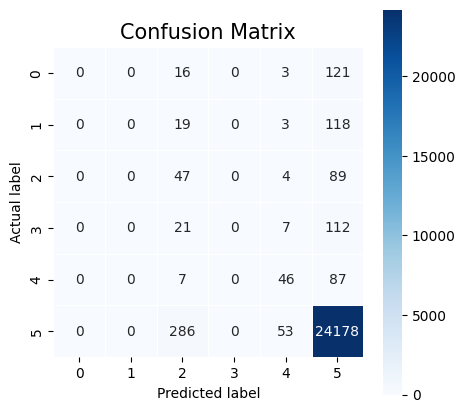

Epoch 1/100, Avg Val Loss: 0.0424, Val Accuracy: 0.9625
Epoch 1/100, Total Avg Val Loss: 0.0424, Total Avg Val Accuracy: 0.9625
Save new model at avg_val_loss: 0.0424


100%|██████████| 395/395 [00:32<00:00, 12.04it/s]


Epoch 2/100, Train Loss: 0.0407


100%|██████████| 99/99 [00:02<00:00, 34.56it/s]


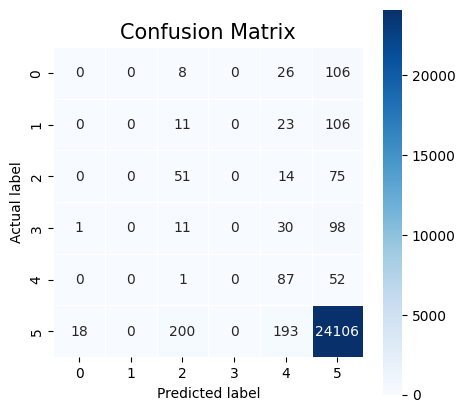

Epoch 2/100, Avg Val Loss: 0.0406, Val Accuracy: 0.9614
Epoch 2/100, Total Avg Val Loss: 0.0406, Total Avg Val Accuracy: 0.9614
Save new model at avg_val_loss: 0.0406


100%|██████████| 395/395 [00:32<00:00, 12.04it/s]


Epoch 3/100, Train Loss: 0.0389


100%|██████████| 99/99 [00:02<00:00, 34.40it/s]


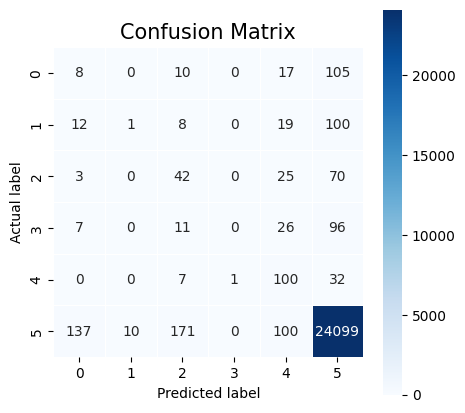

Epoch 3/100, Avg Val Loss: 0.0387, Val Accuracy: 0.9617
Epoch 3/100, Total Avg Val Loss: 0.0387, Total Avg Val Accuracy: 0.9617
Save new model at avg_val_loss: 0.0387


100%|██████████| 395/395 [00:32<00:00, 12.03it/s]


Epoch 4/100, Train Loss: 0.0372


100%|██████████| 99/99 [00:02<00:00, 34.51it/s]


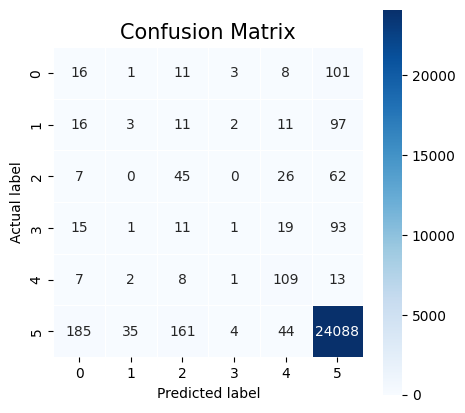

Epoch 4/100, Avg Val Loss: 0.0366, Val Accuracy: 0.9621
Epoch 4/100, Total Avg Val Loss: 0.0366, Total Avg Val Accuracy: 0.9621
Save new model at avg_val_loss: 0.0366


100%|██████████| 395/395 [00:32<00:00, 12.06it/s]


Epoch 5/100, Train Loss: 0.0354


100%|██████████| 99/99 [00:02<00:00, 34.24it/s]


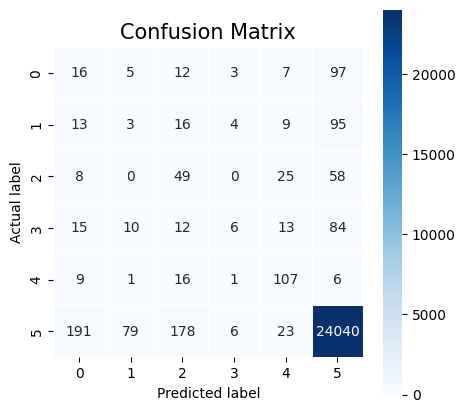

Epoch 5/100, Avg Val Loss: 0.0346, Val Accuracy: 0.9605
Epoch 5/100, Total Avg Val Loss: 0.0346, Total Avg Val Accuracy: 0.9605
Save new model at avg_val_loss: 0.0346


100%|██████████| 395/395 [00:32<00:00, 12.04it/s]


Epoch 6/100, Train Loss: 0.0336


100%|██████████| 99/99 [00:02<00:00, 34.45it/s]


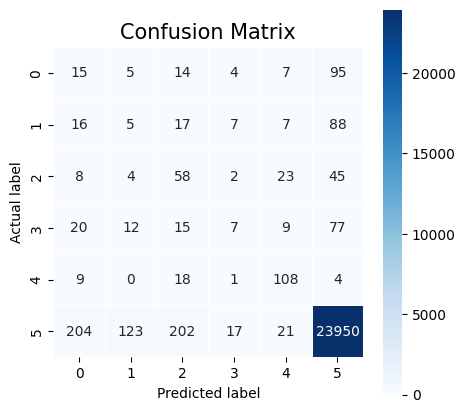

Epoch 6/100, Avg Val Loss: 0.0325, Val Accuracy: 0.9574
Epoch 6/100, Total Avg Val Loss: 0.0325, Total Avg Val Accuracy: 0.9574
Save new model at avg_val_loss: 0.0325


100%|██████████| 395/395 [00:32<00:00, 12.07it/s]


Epoch 7/100, Train Loss: 0.0319


100%|██████████| 99/99 [00:02<00:00, 34.42it/s]


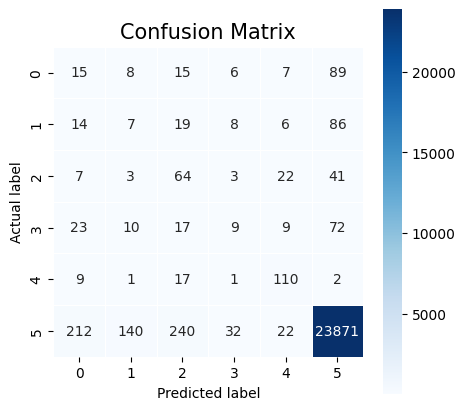

Epoch 7/100, Avg Val Loss: 0.0309, Val Accuracy: 0.9548
Epoch 7/100, Total Avg Val Loss: 0.0309, Total Avg Val Accuracy: 0.9548
Save new model at avg_val_loss: 0.0309


100%|██████████| 395/395 [00:32<00:00, 12.07it/s]


Epoch 8/100, Train Loss: 0.0303


100%|██████████| 99/99 [00:02<00:00, 34.23it/s]


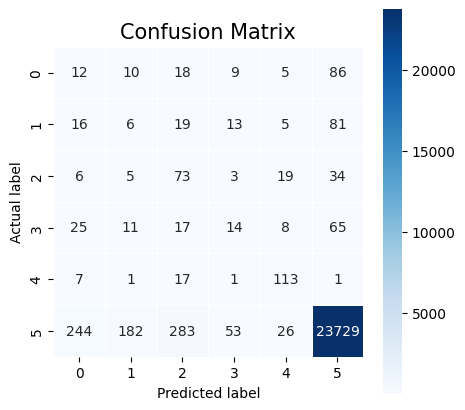

Epoch 8/100, Avg Val Loss: 0.0294, Val Accuracy: 0.9496
Epoch 8/100, Total Avg Val Loss: 0.0294, Total Avg Val Accuracy: 0.9496
Save new model at avg_val_loss: 0.0294


100%|██████████| 395/395 [00:32<00:00, 12.05it/s]


Epoch 9/100, Train Loss: 0.0290


100%|██████████| 99/99 [00:02<00:00, 34.32it/s]


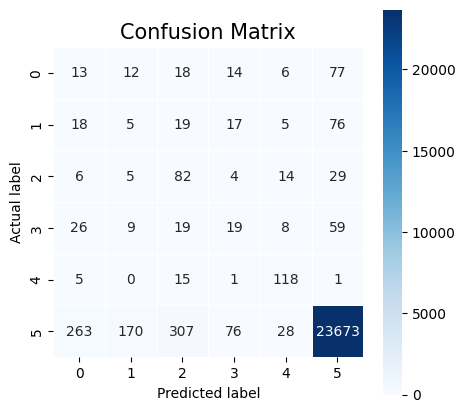

Epoch 9/100, Avg Val Loss: 0.0283, Val Accuracy: 0.9482
Epoch 9/100, Total Avg Val Loss: 0.0283, Total Avg Val Accuracy: 0.9482
Save new model at avg_val_loss: 0.0283


100%|██████████| 395/395 [00:32<00:00, 12.05it/s]


Epoch 10/100, Train Loss: 0.0279


100%|██████████| 99/99 [00:02<00:00, 34.23it/s]


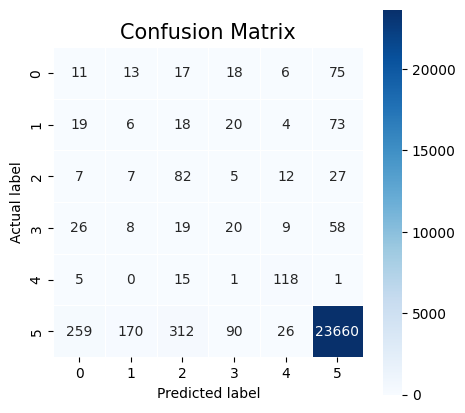

Epoch 10/100, Avg Val Loss: 0.0276, Val Accuracy: 0.9477
Epoch 10/100, Total Avg Val Loss: 0.0276, Total Avg Val Accuracy: 0.9477
Save new model at avg_val_loss: 0.0276


100%|██████████| 395/395 [00:32<00:00, 12.04it/s]


Epoch 11/100, Train Loss: 0.0270


100%|██████████| 99/99 [00:02<00:00, 34.35it/s]


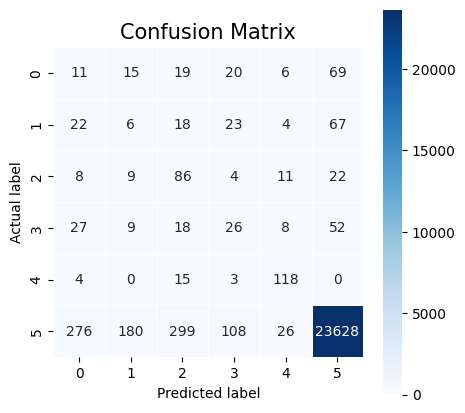

Epoch 11/100, Avg Val Loss: 0.0269, Val Accuracy: 0.9468
Epoch 11/100, Total Avg Val Loss: 0.0269, Total Avg Val Accuracy: 0.9468
Save new model at avg_val_loss: 0.0269


100%|██████████| 395/395 [00:32<00:00, 12.06it/s]


Epoch 12/100, Train Loss: 0.0262


100%|██████████| 99/99 [00:02<00:00, 34.46it/s]


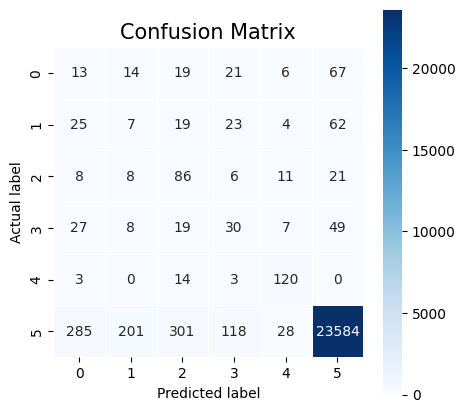

Epoch 12/100, Avg Val Loss: 0.0263, Val Accuracy: 0.9454
Epoch 12/100, Total Avg Val Loss: 0.0263, Total Avg Val Accuracy: 0.9454
Save new model at avg_val_loss: 0.0263


100%|██████████| 395/395 [00:32<00:00, 12.04it/s]


Epoch 13/100, Train Loss: 0.0255


100%|██████████| 99/99 [00:02<00:00, 34.47it/s]


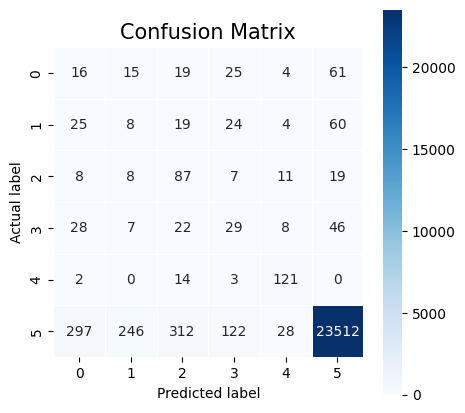

Epoch 13/100, Avg Val Loss: 0.0258, Val Accuracy: 0.9427
Epoch 13/100, Total Avg Val Loss: 0.0258, Total Avg Val Accuracy: 0.9427
Save new model at avg_val_loss: 0.0258


100%|██████████| 395/395 [00:32<00:00, 12.06it/s]


Epoch 14/100, Train Loss: 0.0248


100%|██████████| 99/99 [00:02<00:00, 34.45it/s]


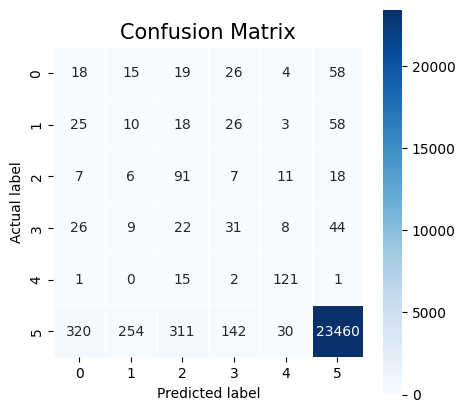

Epoch 14/100, Avg Val Loss: 0.0253, Val Accuracy: 0.9411
Epoch 14/100, Total Avg Val Loss: 0.0253, Total Avg Val Accuracy: 0.9411
Save new model at avg_val_loss: 0.0253


100%|██████████| 395/395 [00:32<00:00, 12.10it/s]


Epoch 15/100, Train Loss: 0.0241


100%|██████████| 99/99 [00:02<00:00, 34.56it/s]


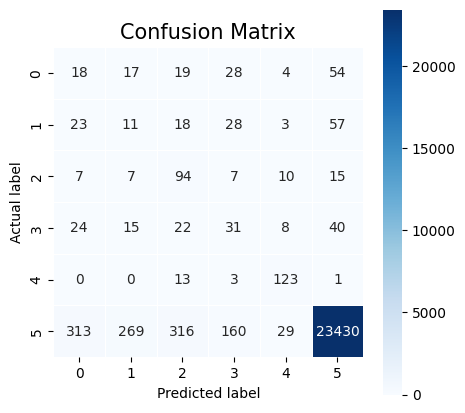

Epoch 15/100, Avg Val Loss: 0.0248, Val Accuracy: 0.9401
Epoch 15/100, Total Avg Val Loss: 0.0248, Total Avg Val Accuracy: 0.9401
Save new model at avg_val_loss: 0.0248


100%|██████████| 395/395 [00:32<00:00, 12.07it/s]


Epoch 16/100, Train Loss: 0.0236


100%|██████████| 99/99 [00:02<00:00, 34.50it/s]


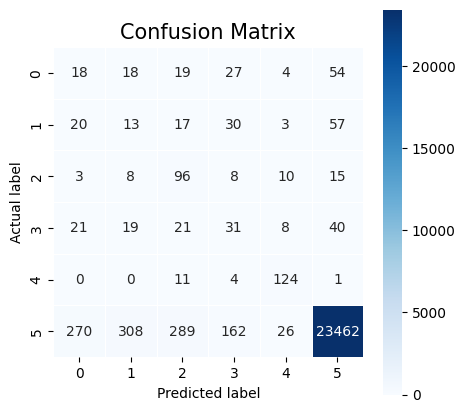

Epoch 16/100, Avg Val Loss: 0.0245, Val Accuracy: 0.9416
Epoch 16/100, Total Avg Val Loss: 0.0245, Total Avg Val Accuracy: 0.9416
Save new model at avg_val_loss: 0.0245


100%|██████████| 395/395 [00:32<00:00, 12.07it/s]


Epoch 17/100, Train Loss: 0.0230


100%|██████████| 99/99 [00:02<00:00, 34.34it/s]


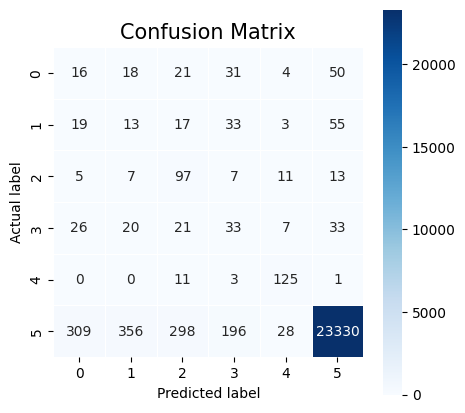

Epoch 17/100, Avg Val Loss: 0.0240, Val Accuracy: 0.9364
Epoch 17/100, Total Avg Val Loss: 0.0240, Total Avg Val Accuracy: 0.9364
Save new model at avg_val_loss: 0.0240


100%|██████████| 395/395 [00:32<00:00, 12.07it/s]


Epoch 18/100, Train Loss: 0.0224


100%|██████████| 99/99 [00:02<00:00, 34.39it/s]


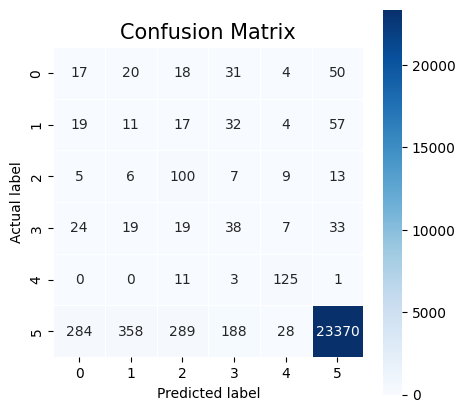

Epoch 18/100, Avg Val Loss: 0.0236, Val Accuracy: 0.9383
Epoch 18/100, Total Avg Val Loss: 0.0236, Total Avg Val Accuracy: 0.9383
Save new model at avg_val_loss: 0.0236


100%|██████████| 395/395 [00:32<00:00, 12.10it/s]


Epoch 19/100, Train Loss: 0.0218


100%|██████████| 99/99 [00:02<00:00, 34.41it/s]


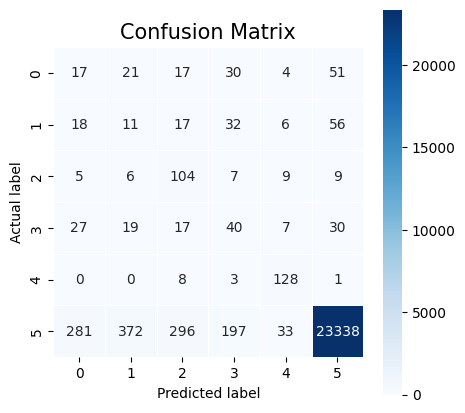

Epoch 19/100, Avg Val Loss: 0.0233, Val Accuracy: 0.9374
Epoch 19/100, Total Avg Val Loss: 0.0233, Total Avg Val Accuracy: 0.9374
Save new model at avg_val_loss: 0.0233


100%|██████████| 395/395 [00:32<00:00, 12.12it/s]


Epoch 20/100, Train Loss: 0.0213


100%|██████████| 99/99 [00:02<00:00, 34.28it/s]


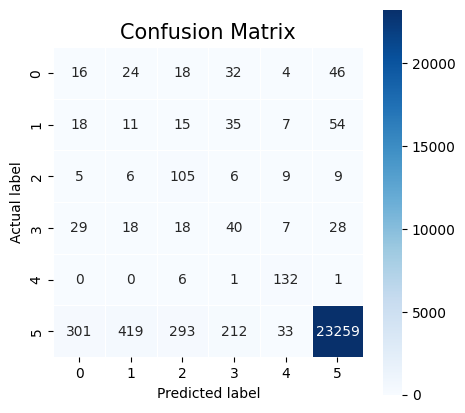

Epoch 20/100, Avg Val Loss: 0.0229, Val Accuracy: 0.9344
Epoch 20/100, Total Avg Val Loss: 0.0229, Total Avg Val Accuracy: 0.9344
Save new model at avg_val_loss: 0.0229


100%|██████████| 395/395 [00:32<00:00, 12.09it/s]


Epoch 21/100, Train Loss: 0.0208


100%|██████████| 99/99 [00:02<00:00, 34.14it/s]


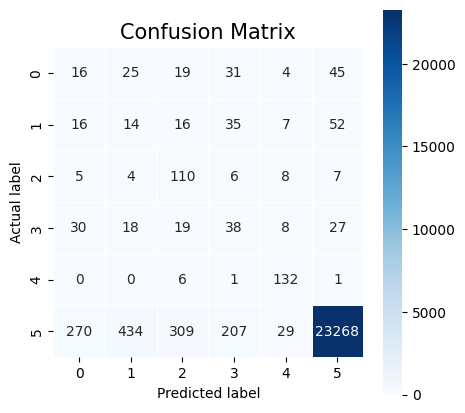

Epoch 21/100, Avg Val Loss: 0.0227, Val Accuracy: 0.9350
Epoch 21/100, Total Avg Val Loss: 0.0227, Total Avg Val Accuracy: 0.9350
Save new model at avg_val_loss: 0.0227


100%|██████████| 395/395 [00:32<00:00, 12.13it/s]


Epoch 22/100, Train Loss: 0.0202


100%|██████████| 99/99 [00:02<00:00, 34.25it/s]


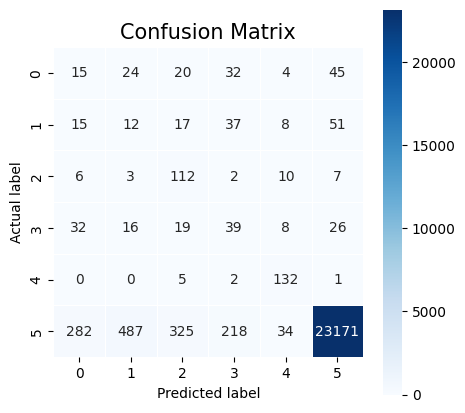

Epoch 22/100, Avg Val Loss: 0.0225, Val Accuracy: 0.9312
Epoch 22/100, Total Avg Val Loss: 0.0225, Total Avg Val Accuracy: 0.9312
Save new model at avg_val_loss: 0.0225


100%|██████████| 395/395 [00:32<00:00, 12.12it/s]


Epoch 23/100, Train Loss: 0.0197


100%|██████████| 99/99 [00:02<00:00, 34.19it/s]


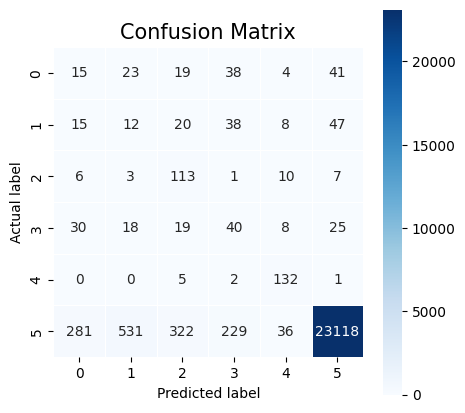

Epoch 23/100, Avg Val Loss: 0.0223, Val Accuracy: 0.9291
Epoch 23/100, Total Avg Val Loss: 0.0223, Total Avg Val Accuracy: 0.9291
Save new model at avg_val_loss: 0.0223


100%|██████████| 395/395 [00:32<00:00, 12.13it/s]


Epoch 24/100, Train Loss: 0.0193


100%|██████████| 99/99 [00:02<00:00, 34.40it/s]


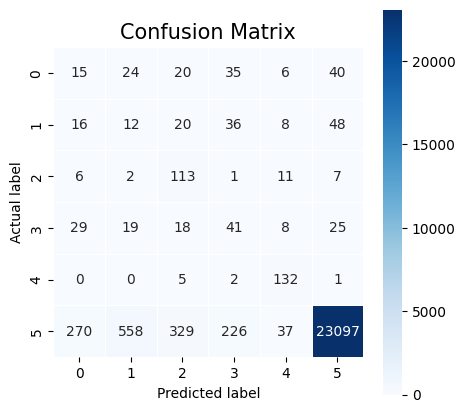

Epoch 24/100, Avg Val Loss: 0.0223, Val Accuracy: 0.9283
Epoch 24/100, Total Avg Val Loss: 0.0223, Total Avg Val Accuracy: 0.9283


100%|██████████| 395/395 [00:32<00:00, 12.11it/s]


Epoch 25/100, Train Loss: 0.0190


100%|██████████| 99/99 [00:02<00:00, 34.31it/s]


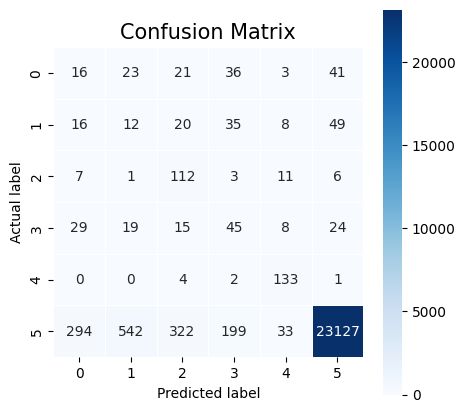

Epoch 25/100, Avg Val Loss: 0.0221, Val Accuracy: 0.9297
Epoch 25/100, Total Avg Val Loss: 0.0221, Total Avg Val Accuracy: 0.9297
Save new model at avg_val_loss: 0.0221


100%|██████████| 395/395 [00:32<00:00, 12.11it/s]


Epoch 26/100, Train Loss: 0.0184


100%|██████████| 99/99 [00:02<00:00, 34.21it/s]


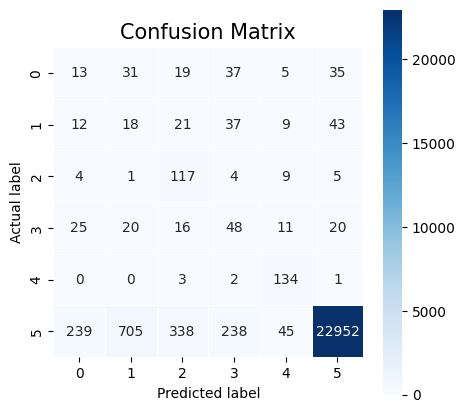

Epoch 26/100, Avg Val Loss: 0.0224, Val Accuracy: 0.9233
Epoch 26/100, Total Avg Val Loss: 0.0224, Total Avg Val Accuracy: 0.9233


100%|██████████| 395/395 [00:32<00:00, 12.14it/s]


Epoch 27/100, Train Loss: 0.0182


100%|██████████| 99/99 [00:02<00:00, 34.18it/s]


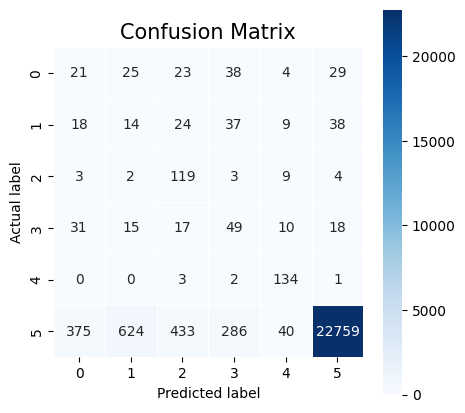

Epoch 27/100, Avg Val Loss: 0.0226, Val Accuracy: 0.9159
Epoch 27/100, Total Avg Val Loss: 0.0226, Total Avg Val Accuracy: 0.9159


100%|██████████| 395/395 [00:32<00:00, 12.10it/s]


Epoch 28/100, Train Loss: 0.0178


100%|██████████| 99/99 [00:02<00:00, 34.30it/s]


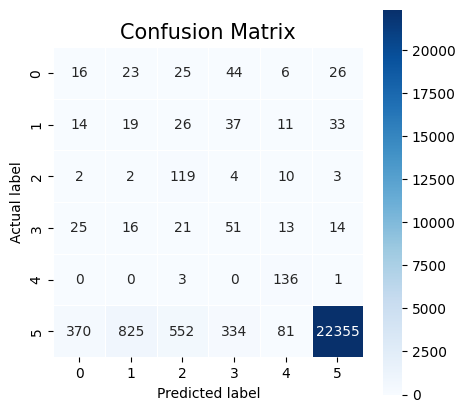

Epoch 28/100, Avg Val Loss: 0.0240, Val Accuracy: 0.9000
Epoch 28/100, Total Avg Val Loss: 0.0240, Total Avg Val Accuracy: 0.9000


100%|██████████| 395/395 [00:32<00:00, 12.13it/s]


Epoch 29/100, Train Loss: 0.0176


100%|██████████| 99/99 [00:02<00:00, 33.81it/s]


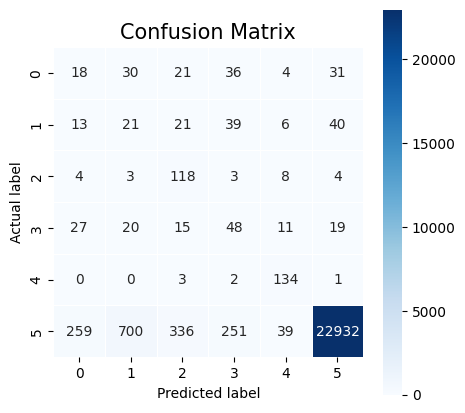

Epoch 29/100, Avg Val Loss: 0.0220, Val Accuracy: 0.9228
Epoch 29/100, Total Avg Val Loss: 0.0220, Total Avg Val Accuracy: 0.9228
Save new model at avg_val_loss: 0.0220


100%|██████████| 395/395 [00:32<00:00, 12.12it/s]


Epoch 30/100, Train Loss: 0.0173


100%|██████████| 99/99 [00:02<00:00, 33.69it/s]


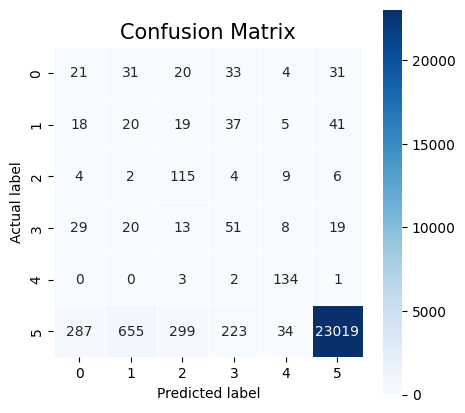

Epoch 30/100, Avg Val Loss: 0.0216, Val Accuracy: 0.9264
Epoch 30/100, Total Avg Val Loss: 0.0216, Total Avg Val Accuracy: 0.9264
Save new model at avg_val_loss: 0.0216


100%|██████████| 395/395 [00:32<00:00, 12.16it/s]


Epoch 31/100, Train Loss: 0.0170


100%|██████████| 99/99 [00:02<00:00, 33.57it/s]


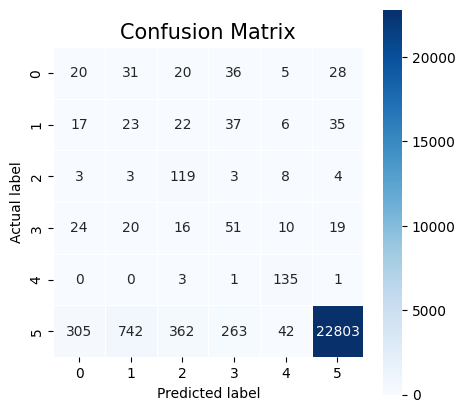

Epoch 31/100, Avg Val Loss: 0.0222, Val Accuracy: 0.9181
Epoch 31/100, Total Avg Val Loss: 0.0222, Total Avg Val Accuracy: 0.9181


100%|██████████| 395/395 [00:32<00:00, 12.19it/s]


Epoch 32/100, Train Loss: 0.0169


100%|██████████| 99/99 [00:02<00:00, 33.43it/s]


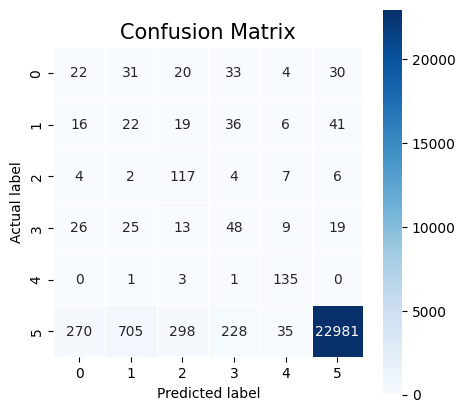

Epoch 32/100, Avg Val Loss: 0.0217, Val Accuracy: 0.9250
Epoch 32/100, Total Avg Val Loss: 0.0217, Total Avg Val Accuracy: 0.9250


100%|██████████| 395/395 [00:32<00:00, 12.18it/s]


Epoch 33/100, Train Loss: 0.0165


100%|██████████| 99/99 [00:02<00:00, 33.55it/s]


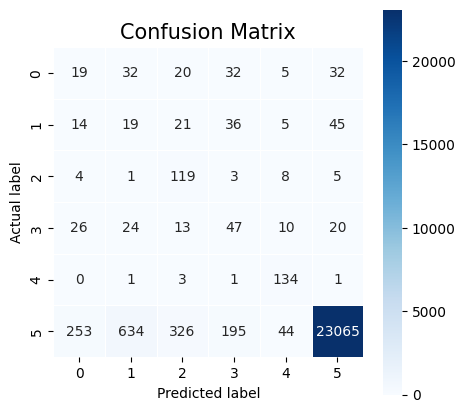

Epoch 33/100, Avg Val Loss: 0.0220, Val Accuracy: 0.9281
Epoch 33/100, Total Avg Val Loss: 0.0220, Total Avg Val Accuracy: 0.9281


100%|██████████| 395/395 [00:32<00:00, 12.19it/s]


Epoch 34/100, Train Loss: 0.0162


100%|██████████| 99/99 [00:02<00:00, 33.44it/s]


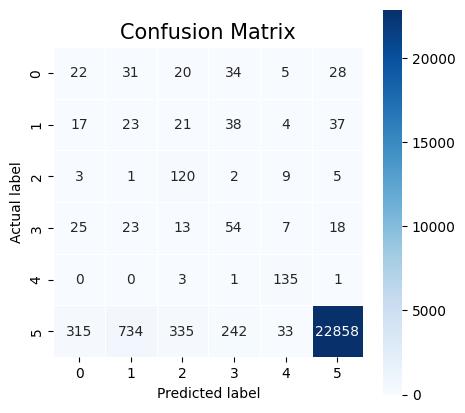

Epoch 34/100, Avg Val Loss: 0.0220, Val Accuracy: 0.9205
Epoch 34/100, Total Avg Val Loss: 0.0220, Total Avg Val Accuracy: 0.9205


100%|██████████| 395/395 [00:32<00:00, 12.18it/s]


Epoch 35/100, Train Loss: 0.0160


100%|██████████| 99/99 [00:02<00:00, 33.84it/s]


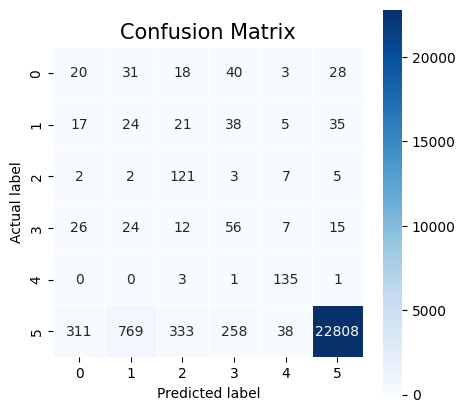

Epoch 35/100, Avg Val Loss: 0.0220, Val Accuracy: 0.9186
Epoch 35/100, Total Avg Val Loss: 0.0220, Total Avg Val Accuracy: 0.9186


100%|██████████| 395/395 [00:32<00:00, 12.13it/s]


Epoch 36/100, Train Loss: 0.0159


100%|██████████| 99/99 [00:02<00:00, 33.91it/s]


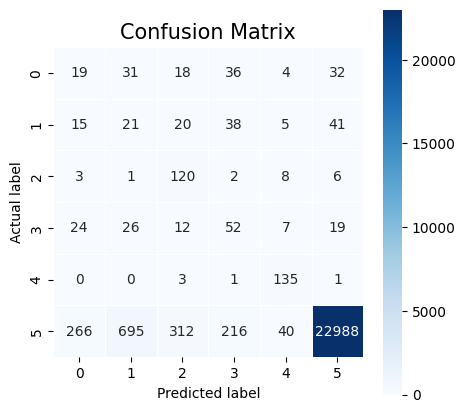

Epoch 36/100, Avg Val Loss: 0.0219, Val Accuracy: 0.9254
Epoch 36/100, Total Avg Val Loss: 0.0219, Total Avg Val Accuracy: 0.9254


100%|██████████| 395/395 [00:33<00:00, 11.65it/s]


Epoch 37/100, Train Loss: 0.0155


100%|██████████| 99/99 [00:02<00:00, 33.53it/s]


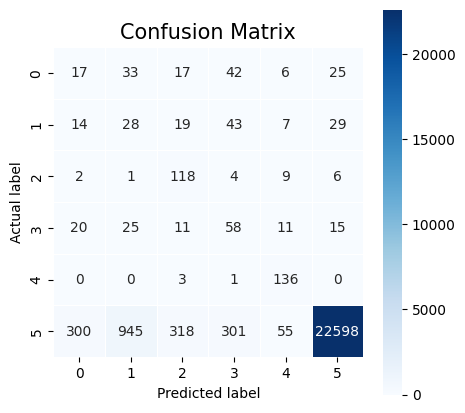

Epoch 37/100, Avg Val Loss: 0.0224, Val Accuracy: 0.9103
Epoch 37/100, Total Avg Val Loss: 0.0224, Total Avg Val Accuracy: 0.9103


100%|██████████| 395/395 [00:32<00:00, 12.18it/s]


Epoch 38/100, Train Loss: 0.0154


100%|██████████| 99/99 [00:02<00:00, 33.73it/s]


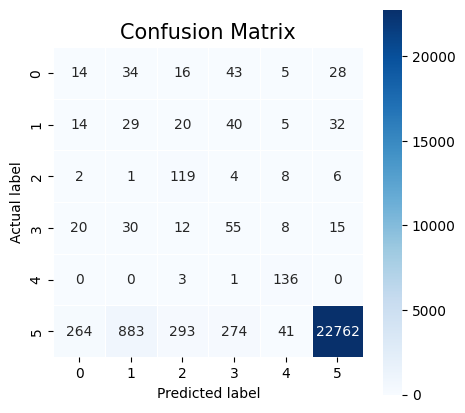

Epoch 38/100, Avg Val Loss: 0.0221, Val Accuracy: 0.9166
Epoch 38/100, Total Avg Val Loss: 0.0221, Total Avg Val Accuracy: 0.9166


100%|██████████| 395/395 [00:32<00:00, 12.15it/s]


Epoch 39/100, Train Loss: 0.0153


100%|██████████| 99/99 [00:02<00:00, 33.98it/s]


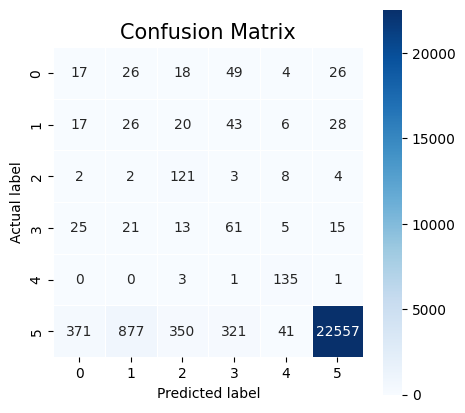

Epoch 39/100, Avg Val Loss: 0.0222, Val Accuracy: 0.9088
Epoch 39/100, Total Avg Val Loss: 0.0222, Total Avg Val Accuracy: 0.9088


100%|██████████| 395/395 [00:32<00:00, 12.14it/s]


Epoch 40/100, Train Loss: 0.0151


100%|██████████| 99/99 [00:02<00:00, 33.87it/s]


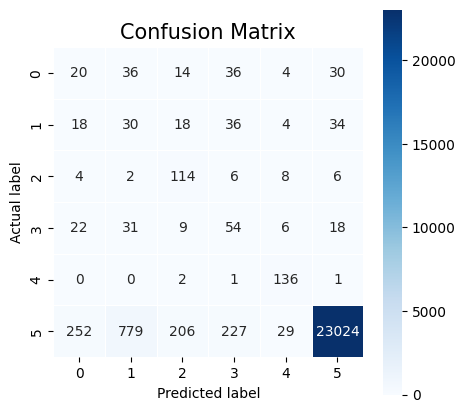

Epoch 40/100, Avg Val Loss: 0.0214, Val Accuracy: 0.9271
Epoch 40/100, Total Avg Val Loss: 0.0214, Total Avg Val Accuracy: 0.9271
Save new model at avg_val_loss: 0.0214


100%|██████████| 395/395 [00:32<00:00, 12.11it/s]


Epoch 41/100, Train Loss: 0.0148


100%|██████████| 99/99 [00:02<00:00, 34.23it/s]


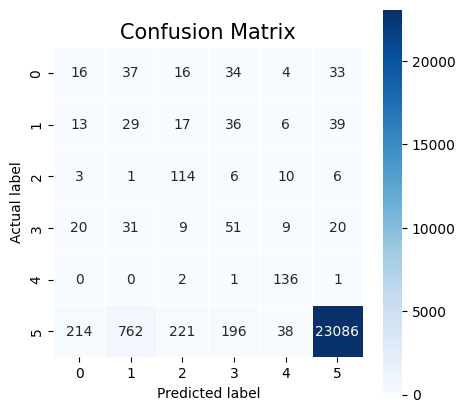

Epoch 41/100, Avg Val Loss: 0.0220, Val Accuracy: 0.9292
Epoch 41/100, Total Avg Val Loss: 0.0220, Total Avg Val Accuracy: 0.9292


100%|██████████| 395/395 [00:32<00:00, 12.09it/s]


Epoch 42/100, Train Loss: 0.0146


100%|██████████| 99/99 [00:02<00:00, 34.17it/s]


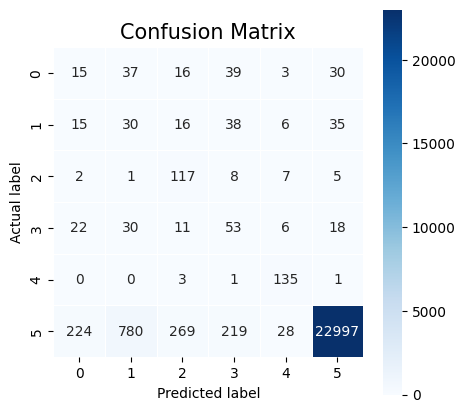

Epoch 42/100, Avg Val Loss: 0.0221, Val Accuracy: 0.9258
Epoch 42/100, Total Avg Val Loss: 0.0221, Total Avg Val Accuracy: 0.9258


100%|██████████| 395/395 [00:32<00:00, 12.10it/s]


Epoch 43/100, Train Loss: 0.0147


100%|██████████| 99/99 [00:02<00:00, 34.37it/s]


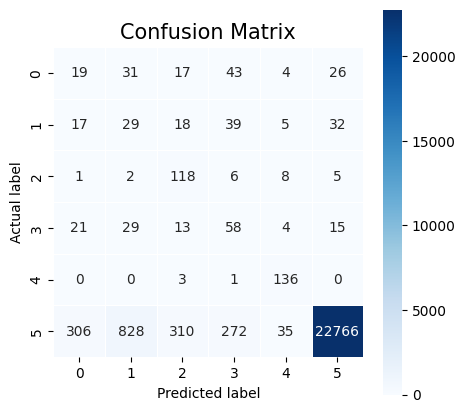

Epoch 43/100, Avg Val Loss: 0.0220, Val Accuracy: 0.9171
Epoch 43/100, Total Avg Val Loss: 0.0220, Total Avg Val Accuracy: 0.9171


100%|██████████| 395/395 [00:32<00:00, 12.11it/s]


Epoch 44/100, Train Loss: 0.0144


100%|██████████| 99/99 [00:02<00:00, 34.12it/s]


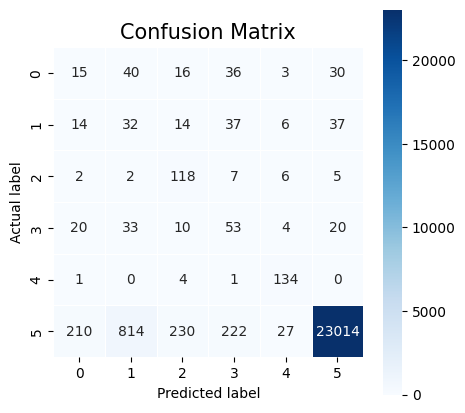

Epoch 44/100, Avg Val Loss: 0.0217, Val Accuracy: 0.9266
Epoch 44/100, Total Avg Val Loss: 0.0217, Total Avg Val Accuracy: 0.9266


100%|██████████| 395/395 [00:32<00:00, 12.08it/s]


Epoch 45/100, Train Loss: 0.0144


100%|██████████| 99/99 [00:02<00:00, 33.74it/s]


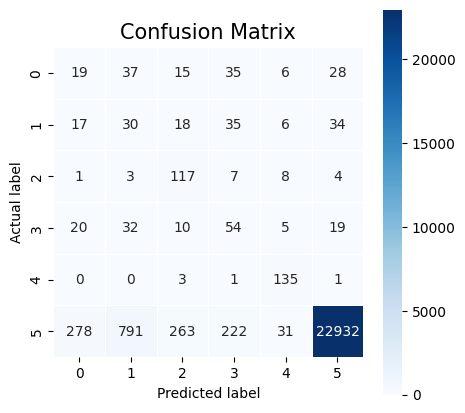

Epoch 45/100, Avg Val Loss: 0.0221, Val Accuracy: 0.9235
Epoch 45/100, Total Avg Val Loss: 0.0221, Total Avg Val Accuracy: 0.9235


100%|██████████| 395/395 [00:32<00:00, 12.11it/s]


Epoch 46/100, Train Loss: 0.0141


100%|██████████| 99/99 [00:02<00:00, 33.64it/s]


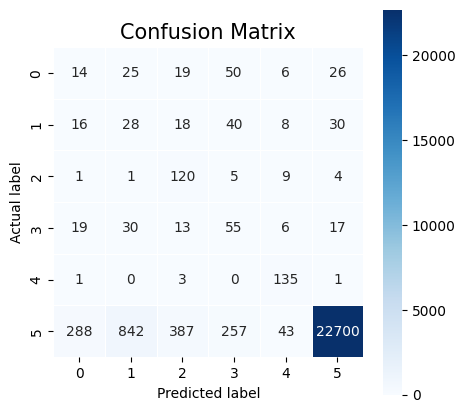

Epoch 46/100, Avg Val Loss: 0.0229, Val Accuracy: 0.9141
Epoch 46/100, Total Avg Val Loss: 0.0229, Total Avg Val Accuracy: 0.9141


100%|██████████| 395/395 [00:32<00:00, 12.09it/s]


Epoch 47/100, Train Loss: 0.0139


100%|██████████| 99/99 [00:02<00:00, 33.88it/s]


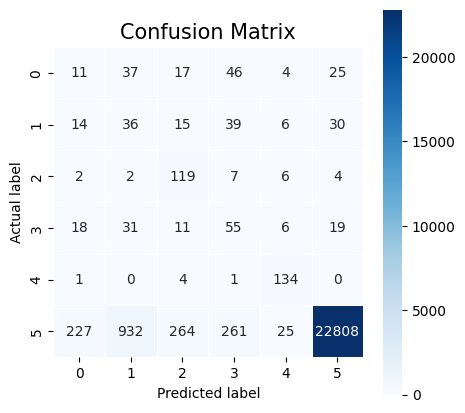

Epoch 47/100, Avg Val Loss: 0.0221, Val Accuracy: 0.9185
Epoch 47/100, Total Avg Val Loss: 0.0221, Total Avg Val Accuracy: 0.9185


100%|██████████| 395/395 [00:32<00:00, 12.08it/s]


Epoch 48/100, Train Loss: 0.0138


100%|██████████| 99/99 [00:02<00:00, 33.71it/s]


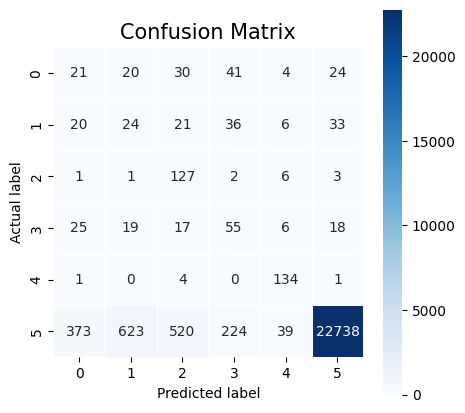

Epoch 48/100, Avg Val Loss: 0.0237, Val Accuracy: 0.9160
Epoch 48/100, Total Avg Val Loss: 0.0237, Total Avg Val Accuracy: 0.9160


100%|██████████| 395/395 [00:32<00:00, 12.07it/s]


Epoch 49/100, Train Loss: 0.0136


100%|██████████| 99/99 [00:02<00:00, 33.85it/s]


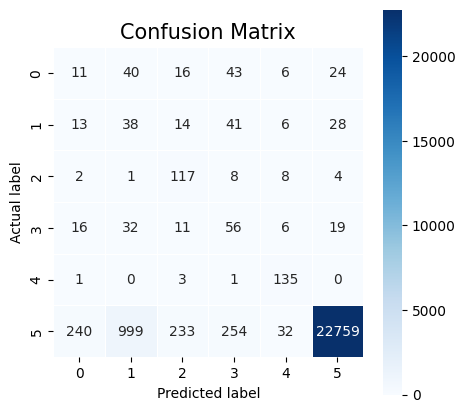

Epoch 49/100, Avg Val Loss: 0.0224, Val Accuracy: 0.9167
Epoch 49/100, Total Avg Val Loss: 0.0224, Total Avg Val Accuracy: 0.9167


100%|██████████| 395/395 [00:32<00:00, 12.07it/s]


Epoch 50/100, Train Loss: 0.0134


100%|██████████| 99/99 [00:02<00:00, 34.11it/s]


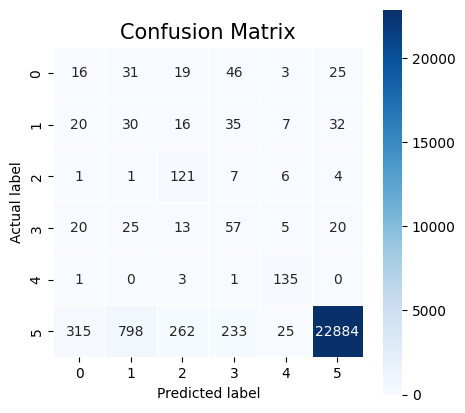

Epoch 50/100, Avg Val Loss: 0.0224, Val Accuracy: 0.9217
Epoch 50/100, Total Avg Val Loss: 0.0224, Total Avg Val Accuracy: 0.9217


100%|██████████| 2/2 [00:00<00:00, 13.89it/s]


Epoch 51/100, Train Loss: 2.0354


100%|██████████| 99/99 [00:02<00:00, 34.39it/s]


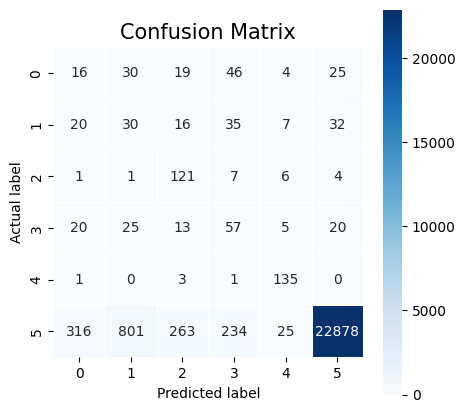

Epoch 51/100, Avg Val Loss: 0.0365, Val Accuracy: 0.9215


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


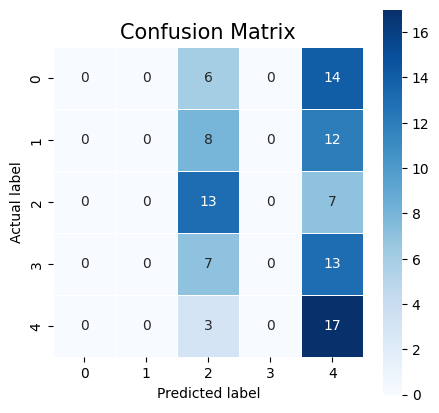

Epoch 51/100, Avg Val Loss: 1.8499, Val Accuracy: 0.3000
Epoch 51/100, Total Avg Val Loss: 0.9432, Total Avg Val Accuracy: 0.9190
Save the first fine-tuned model at avg_val_loss: 0.9432


100%|██████████| 2/2 [00:00<00:00, 13.18it/s]


Epoch 52/100, Train Loss: 2.0207


100%|██████████| 99/99 [00:02<00:00, 33.32it/s]


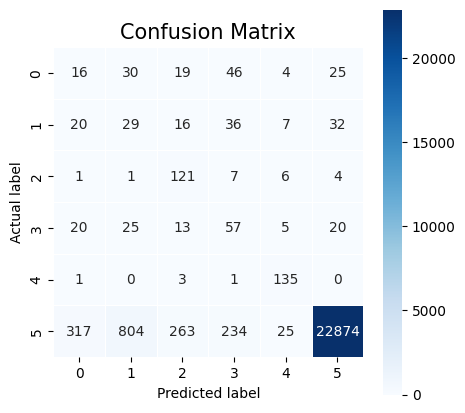

Epoch 52/100, Avg Val Loss: 0.0366, Val Accuracy: 0.9213


100%|██████████| 1/1 [00:00<00:00, 30.55it/s]


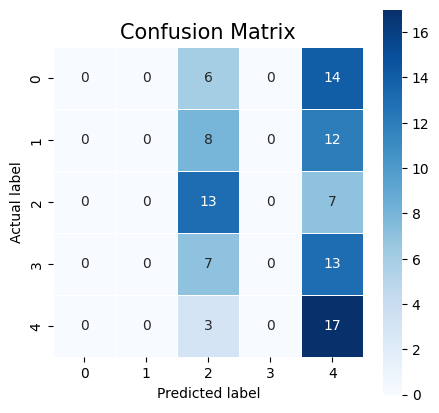

Epoch 52/100, Avg Val Loss: 1.8491, Val Accuracy: 0.3000
Epoch 52/100, Total Avg Val Loss: 0.9428, Total Avg Val Accuracy: 0.9188
Save new model at avg_val_loss: 0.9428


100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 53/100, Train Loss: 2.0244


100%|██████████| 99/99 [00:02<00:00, 34.01it/s]


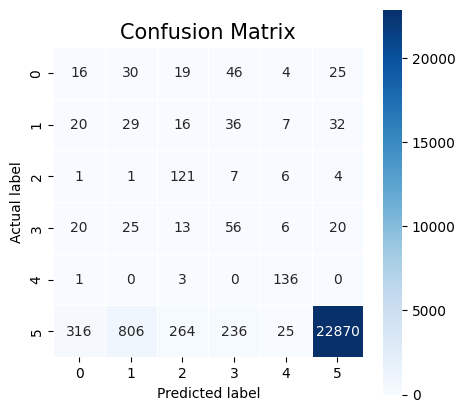

Epoch 53/100, Avg Val Loss: 0.0367, Val Accuracy: 0.9211


100%|██████████| 1/1 [00:00<00:00, 31.64it/s]


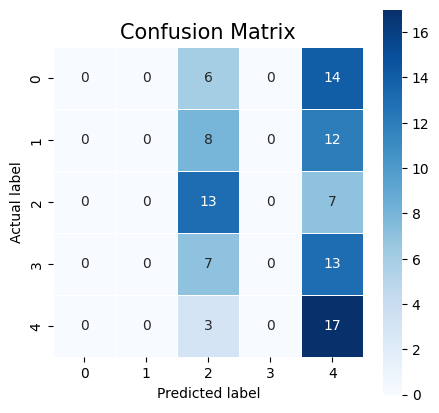

Epoch 53/100, Avg Val Loss: 1.8483, Val Accuracy: 0.3000
Epoch 53/100, Total Avg Val Loss: 0.9425, Total Avg Val Accuracy: 0.9187
Save new model at avg_val_loss: 0.9425


100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 54/100, Train Loss: 2.0012


100%|██████████| 99/99 [00:02<00:00, 34.16it/s]


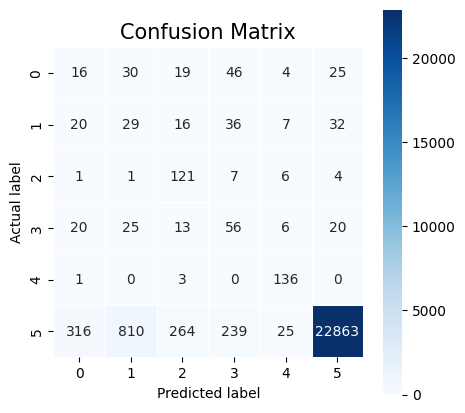

Epoch 54/100, Avg Val Loss: 0.0368, Val Accuracy: 0.9208


100%|██████████| 1/1 [00:00<00:00, 43.05it/s]


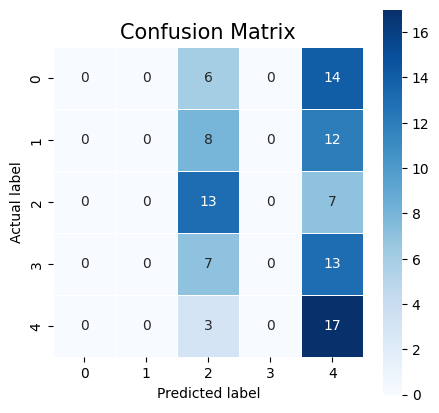

Epoch 54/100, Avg Val Loss: 1.8473, Val Accuracy: 0.3000
Epoch 54/100, Total Avg Val Loss: 0.9420, Total Avg Val Accuracy: 0.9184
Save new model at avg_val_loss: 0.9420


100%|██████████| 2/2 [00:00<00:00, 13.89it/s]


Epoch 55/100, Train Loss: 2.0302


100%|██████████| 99/99 [00:02<00:00, 33.93it/s]


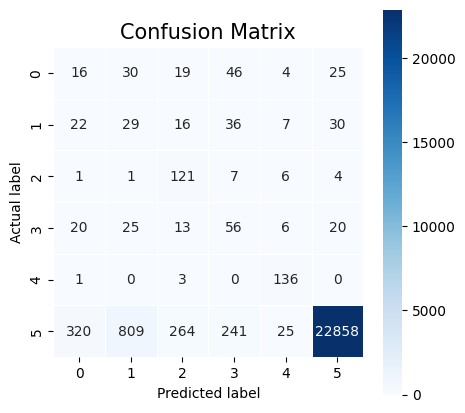

Epoch 55/100, Avg Val Loss: 0.0369, Val Accuracy: 0.9206


100%|██████████| 1/1 [00:00<00:00, 43.33it/s]


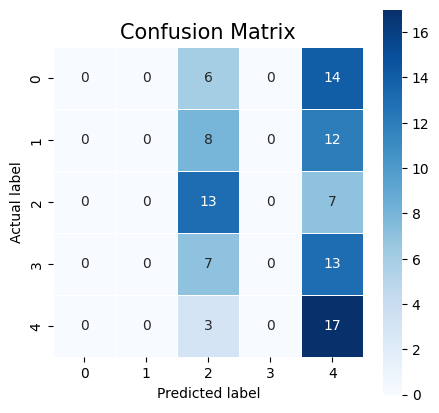

Epoch 55/100, Avg Val Loss: 1.8464, Val Accuracy: 0.3000
Epoch 55/100, Total Avg Val Loss: 0.9416, Total Avg Val Accuracy: 0.9182
Save new model at avg_val_loss: 0.9416


100%|██████████| 2/2 [00:00<00:00, 13.86it/s]


Epoch 56/100, Train Loss: 2.0089


100%|██████████| 99/99 [00:02<00:00, 34.25it/s]


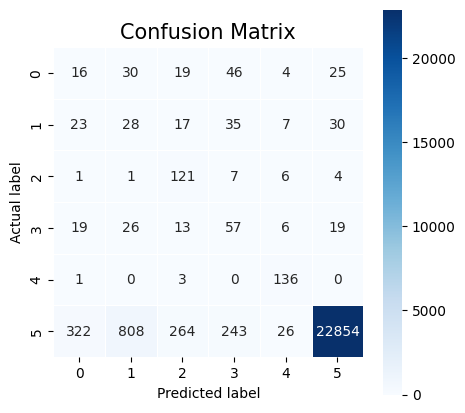

Epoch 56/100, Avg Val Loss: 0.0370, Val Accuracy: 0.9205


100%|██████████| 1/1 [00:00<00:00, 43.85it/s]


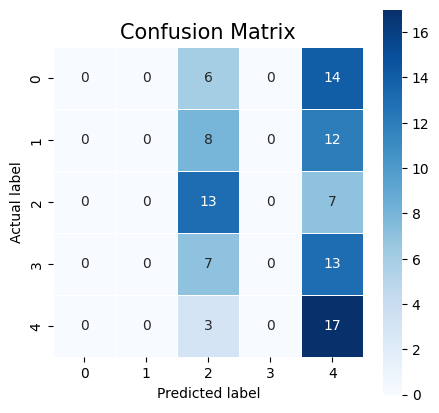

Epoch 56/100, Avg Val Loss: 1.8455, Val Accuracy: 0.3000
Epoch 56/100, Total Avg Val Loss: 0.9412, Total Avg Val Accuracy: 0.9180
Save new model at avg_val_loss: 0.9412


100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


Epoch 57/100, Train Loss: 1.9808


100%|██████████| 99/99 [00:02<00:00, 33.35it/s]


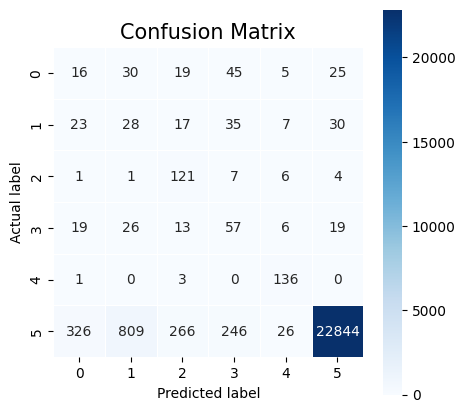

Epoch 57/100, Avg Val Loss: 0.0371, Val Accuracy: 0.9201


100%|██████████| 1/1 [00:00<00:00, 43.26it/s]


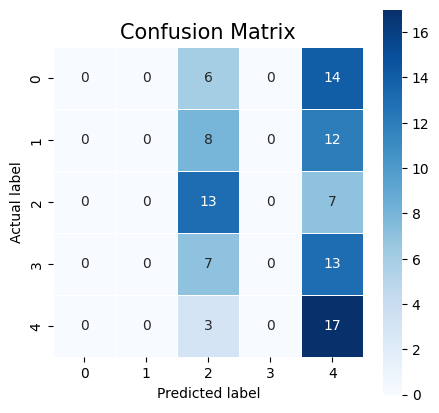

Epoch 57/100, Avg Val Loss: 1.8445, Val Accuracy: 0.3000
Epoch 57/100, Total Avg Val Loss: 0.9408, Total Avg Val Accuracy: 0.9176
Save new model at avg_val_loss: 0.9408


100%|██████████| 2/2 [00:00<00:00, 12.70it/s]


Epoch 58/100, Train Loss: 2.0203


100%|██████████| 99/99 [00:02<00:00, 33.90it/s]


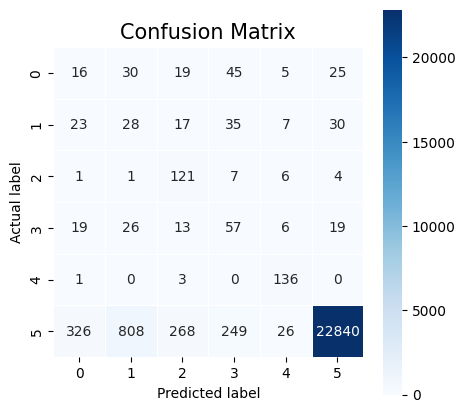

Epoch 58/100, Avg Val Loss: 0.0372, Val Accuracy: 0.9199


100%|██████████| 1/1 [00:00<00:00, 41.98it/s]


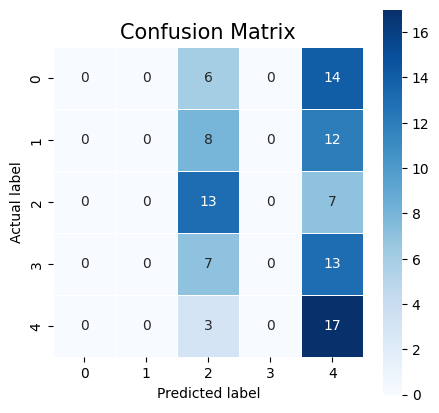

Epoch 58/100, Avg Val Loss: 1.8436, Val Accuracy: 0.3000
Epoch 58/100, Total Avg Val Loss: 0.9404, Total Avg Val Accuracy: 0.9175
Save new model at avg_val_loss: 0.9404


100%|██████████| 2/2 [00:00<00:00, 13.93it/s]


Epoch 59/100, Train Loss: 2.0246


100%|██████████| 99/99 [00:02<00:00, 34.39it/s]


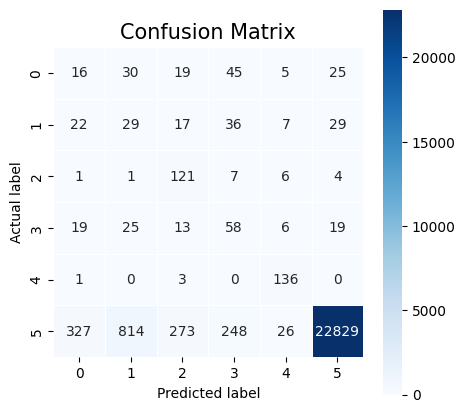

Epoch 59/100, Avg Val Loss: 0.0373, Val Accuracy: 0.9196


100%|██████████| 1/1 [00:00<00:00, 43.14it/s]


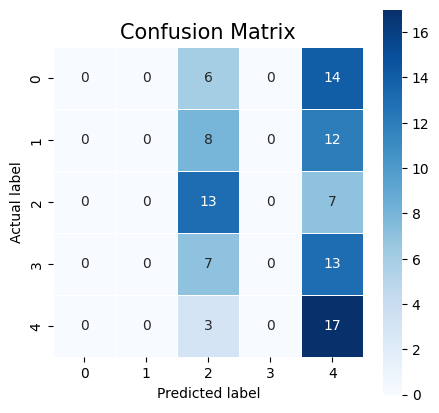

Epoch 59/100, Avg Val Loss: 1.8427, Val Accuracy: 0.3000
Epoch 59/100, Total Avg Val Loss: 0.9400, Total Avg Val Accuracy: 0.9171
Save new model at avg_val_loss: 0.9400


100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epoch 60/100, Train Loss: 2.0303


100%|██████████| 99/99 [00:02<00:00, 33.51it/s]


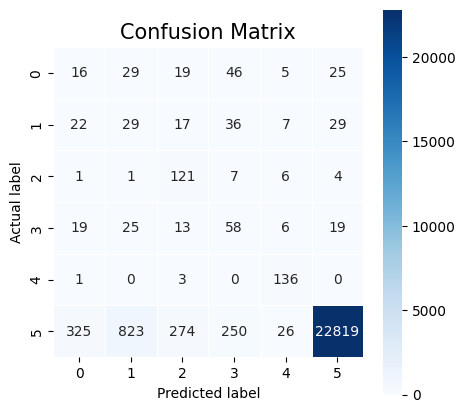

Epoch 60/100, Avg Val Loss: 0.0374, Val Accuracy: 0.9192


100%|██████████| 1/1 [00:00<00:00, 43.75it/s]


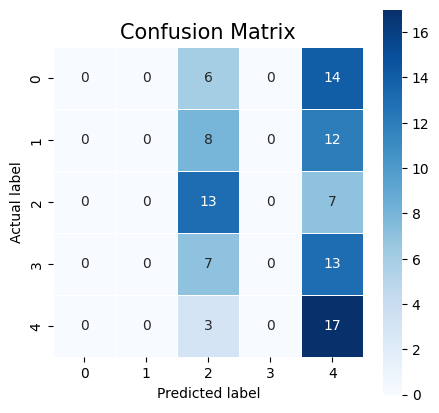

Epoch 60/100, Avg Val Loss: 1.8418, Val Accuracy: 0.3000
Epoch 60/100, Total Avg Val Loss: 0.9396, Total Avg Val Accuracy: 0.9167
Save new model at avg_val_loss: 0.9396


100%|██████████| 2/2 [00:00<00:00, 13.97it/s]


Epoch 61/100, Train Loss: 2.0402


100%|██████████| 99/99 [00:02<00:00, 33.97it/s]


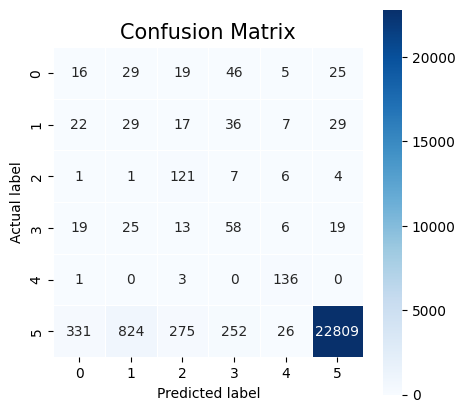

Epoch 61/100, Avg Val Loss: 0.0375, Val Accuracy: 0.9188


100%|██████████| 1/1 [00:00<00:00, 39.88it/s]


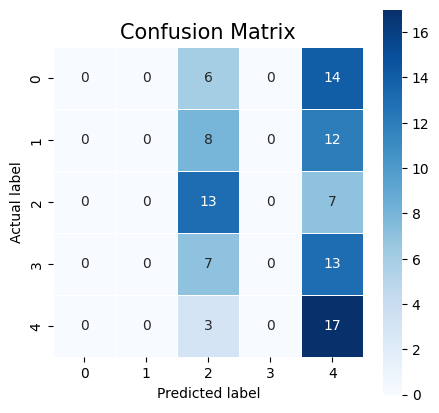

Epoch 61/100, Avg Val Loss: 1.8410, Val Accuracy: 0.3000
Epoch 61/100, Total Avg Val Loss: 0.9392, Total Avg Val Accuracy: 0.9163
Save new model at avg_val_loss: 0.9392


100%|██████████| 2/2 [00:00<00:00, 14.01it/s]


Epoch 62/100, Train Loss: 2.0151


100%|██████████| 99/99 [00:02<00:00, 33.47it/s]


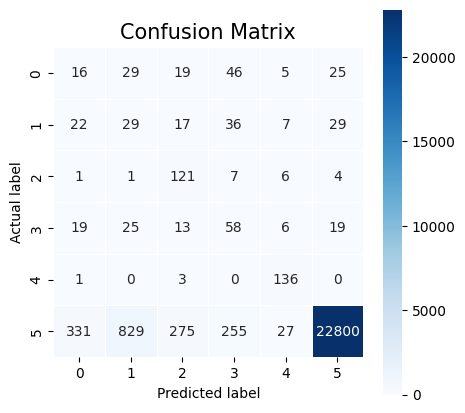

Epoch 62/100, Avg Val Loss: 0.0376, Val Accuracy: 0.9184


100%|██████████| 1/1 [00:00<00:00, 42.35it/s]


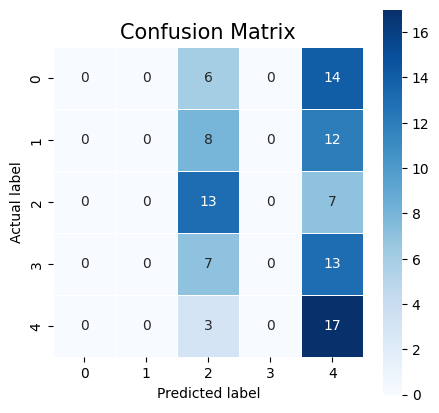

Epoch 62/100, Avg Val Loss: 1.8402, Val Accuracy: 0.3000
Epoch 62/100, Total Avg Val Loss: 0.9389, Total Avg Val Accuracy: 0.9160
Save new model at avg_val_loss: 0.9389


100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 63/100, Train Loss: 2.0133


100%|██████████| 99/99 [00:02<00:00, 34.37it/s]


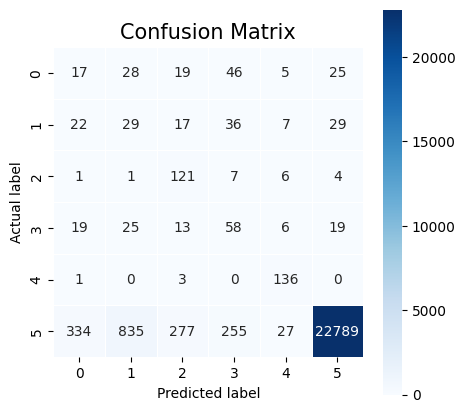

Epoch 63/100, Avg Val Loss: 0.0377, Val Accuracy: 0.9180


100%|██████████| 1/1 [00:00<00:00, 43.17it/s]


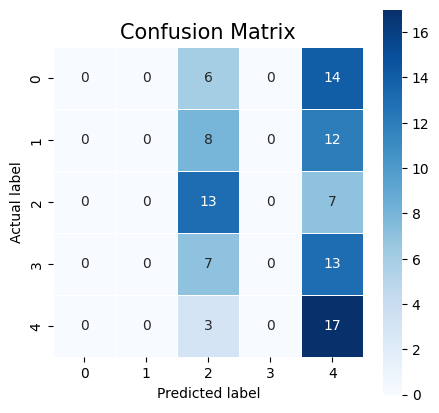

Epoch 63/100, Avg Val Loss: 1.8394, Val Accuracy: 0.3000
Epoch 63/100, Total Avg Val Loss: 0.9385, Total Avg Val Accuracy: 0.9156
Save new model at avg_val_loss: 0.9385


100%|██████████| 2/2 [00:00<00:00, 13.92it/s]


Epoch 64/100, Train Loss: 2.0235


100%|██████████| 99/99 [00:02<00:00, 33.98it/s]


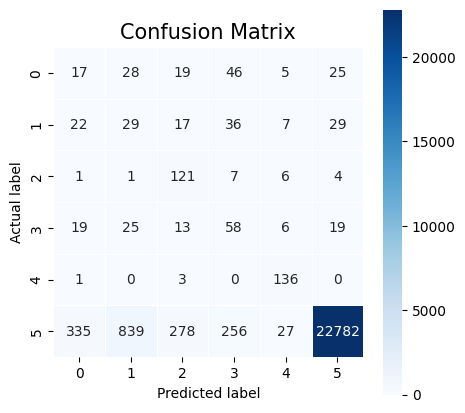

Epoch 64/100, Avg Val Loss: 0.0378, Val Accuracy: 0.9178


100%|██████████| 1/1 [00:00<00:00, 35.52it/s]


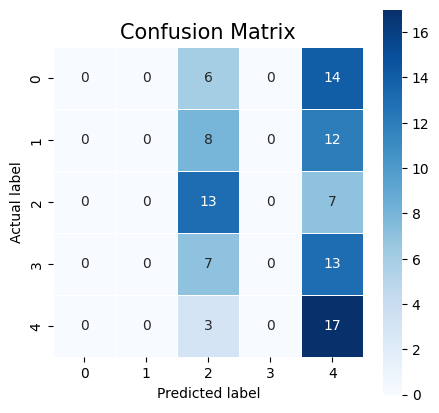

Epoch 64/100, Avg Val Loss: 1.8386, Val Accuracy: 0.3000
Epoch 64/100, Total Avg Val Loss: 0.9382, Total Avg Val Accuracy: 0.9153
Save new model at avg_val_loss: 0.9382


100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 65/100, Train Loss: 2.0006


100%|██████████| 99/99 [00:02<00:00, 33.50it/s]


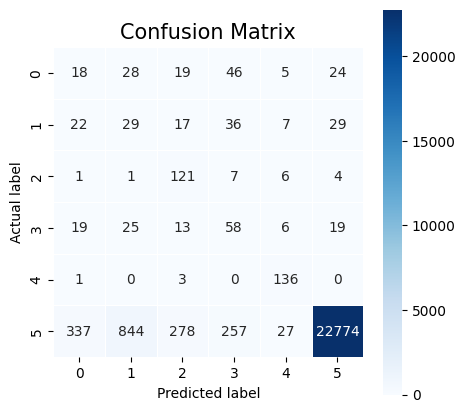

Epoch 65/100, Avg Val Loss: 0.0379, Val Accuracy: 0.9175


100%|██████████| 1/1 [00:00<00:00, 43.39it/s]


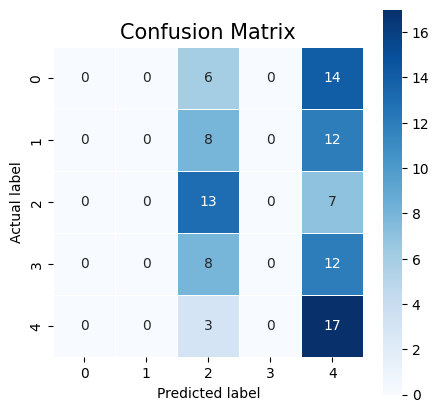

Epoch 65/100, Avg Val Loss: 1.8379, Val Accuracy: 0.3000
Epoch 65/100, Total Avg Val Loss: 0.9379, Total Avg Val Accuracy: 0.9150
Save new model at avg_val_loss: 0.9379


100%|██████████| 2/2 [00:00<00:00, 14.39it/s]


Epoch 66/100, Train Loss: 1.9544


100%|██████████| 99/99 [00:02<00:00, 33.80it/s]


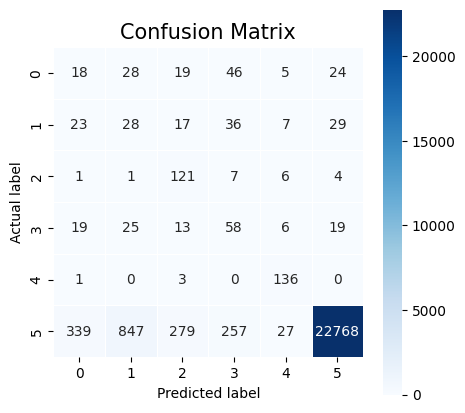

Epoch 66/100, Avg Val Loss: 0.0379, Val Accuracy: 0.9172


100%|██████████| 1/1 [00:00<00:00, 44.04it/s]


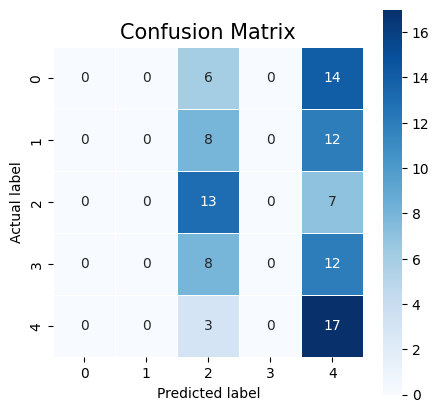

Epoch 66/100, Avg Val Loss: 1.8372, Val Accuracy: 0.3000
Epoch 66/100, Total Avg Val Loss: 0.9376, Total Avg Val Accuracy: 0.9148
Save new model at avg_val_loss: 0.9376


100%|██████████| 2/2 [00:00<00:00, 14.18it/s]


Epoch 67/100, Train Loss: 1.9826


100%|██████████| 99/99 [00:02<00:00, 33.29it/s]


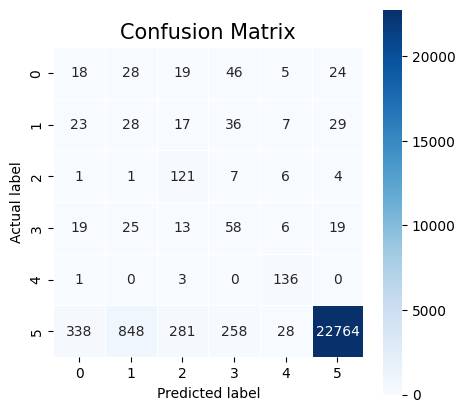

Epoch 67/100, Avg Val Loss: 0.0380, Val Accuracy: 0.9170


100%|██████████| 1/1 [00:00<00:00, 30.67it/s]


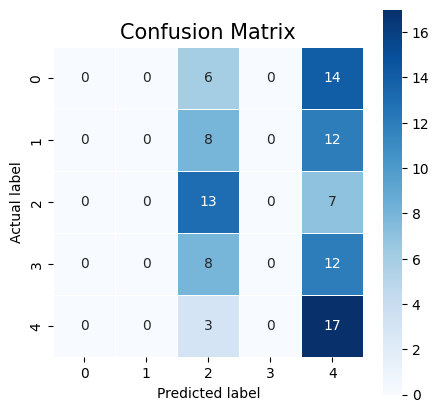

Epoch 67/100, Avg Val Loss: 1.8365, Val Accuracy: 0.3000
Epoch 67/100, Total Avg Val Loss: 0.9373, Total Avg Val Accuracy: 0.9146
Save new model at avg_val_loss: 0.9373


100%|██████████| 2/2 [00:00<00:00, 13.95it/s]


Epoch 68/100, Train Loss: 2.0119


100%|██████████| 99/99 [00:02<00:00, 33.99it/s]


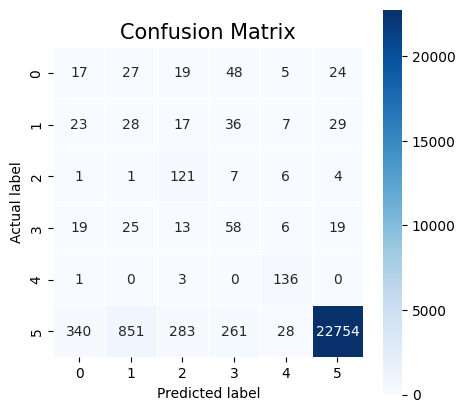

Epoch 68/100, Avg Val Loss: 0.0381, Val Accuracy: 0.9166


100%|██████████| 1/1 [00:00<00:00, 44.20it/s]


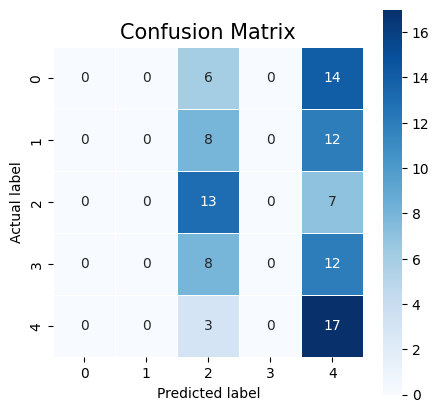

Epoch 68/100, Avg Val Loss: 1.8358, Val Accuracy: 0.3000
Epoch 68/100, Total Avg Val Loss: 0.9370, Total Avg Val Accuracy: 0.9142
Save new model at avg_val_loss: 0.9370


100%|██████████| 2/2 [00:00<00:00, 14.23it/s]


Epoch 69/100, Train Loss: 2.0459


100%|██████████| 99/99 [00:02<00:00, 34.32it/s]


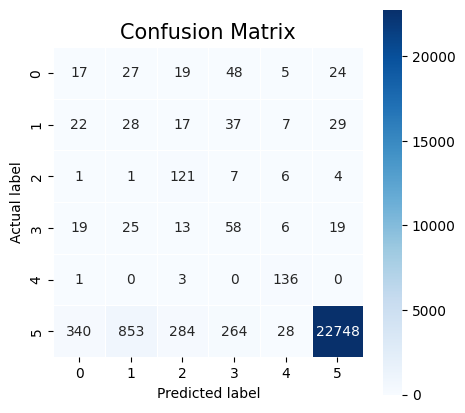

Epoch 69/100, Avg Val Loss: 0.0382, Val Accuracy: 0.9164


100%|██████████| 1/1 [00:00<00:00, 42.26it/s]


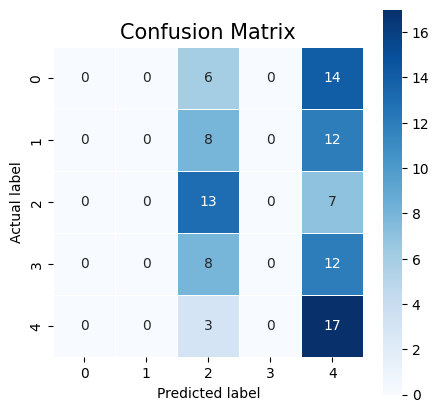

Epoch 69/100, Avg Val Loss: 1.8352, Val Accuracy: 0.3000
Epoch 69/100, Total Avg Val Loss: 0.9367, Total Avg Val Accuracy: 0.9139
Save new model at avg_val_loss: 0.9367


100%|██████████| 2/2 [00:00<00:00, 14.10it/s]


Epoch 70/100, Train Loss: 2.0139


100%|██████████| 99/99 [00:02<00:00, 33.60it/s]


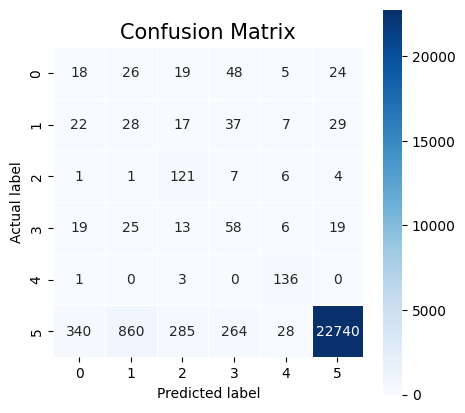

Epoch 70/100, Avg Val Loss: 0.0383, Val Accuracy: 0.9161


100%|██████████| 1/1 [00:00<00:00, 44.32it/s]


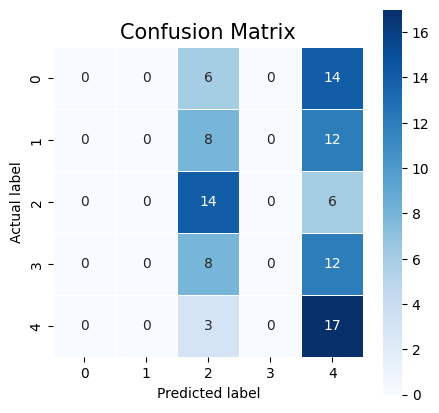

Epoch 70/100, Avg Val Loss: 1.8345, Val Accuracy: 0.3100
Epoch 70/100, Total Avg Val Loss: 0.9364, Total Avg Val Accuracy: 0.9137
Save new model at avg_val_loss: 0.9364


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Epoch 71/100, Train Loss: 1.9862


100%|██████████| 99/99 [00:02<00:00, 33.68it/s]


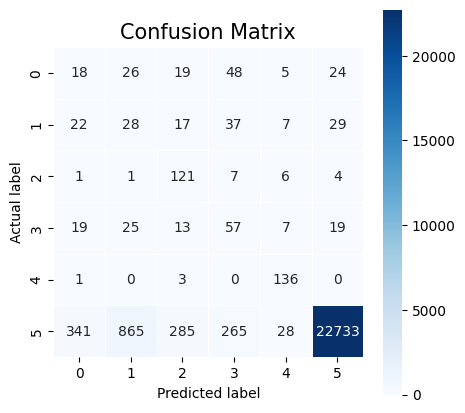

Epoch 71/100, Avg Val Loss: 0.0384, Val Accuracy: 0.9158


100%|██████████| 1/1 [00:00<00:00, 43.75it/s]


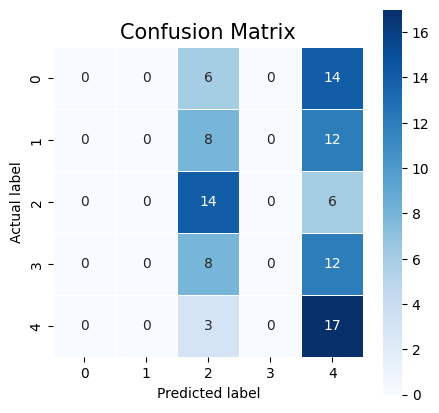

Epoch 71/100, Avg Val Loss: 1.8339, Val Accuracy: 0.3100
Epoch 71/100, Total Avg Val Loss: 0.9361, Total Avg Val Accuracy: 0.9134
Save new model at avg_val_loss: 0.9361


100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Epoch 72/100, Train Loss: 2.0211


100%|██████████| 99/99 [00:02<00:00, 34.34it/s]


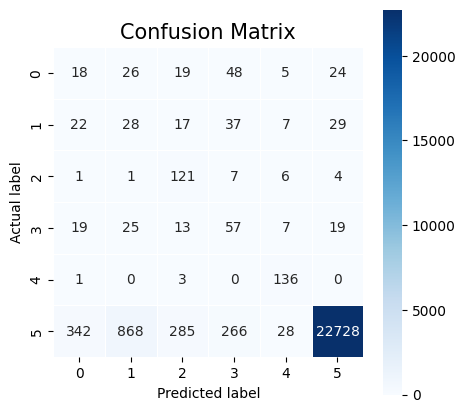

Epoch 72/100, Avg Val Loss: 0.0385, Val Accuracy: 0.9156


100%|██████████| 1/1 [00:00<00:00, 42.80it/s]


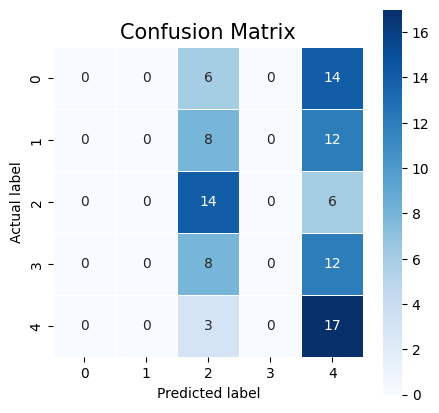

Epoch 72/100, Avg Val Loss: 1.8333, Val Accuracy: 0.3100
Epoch 72/100, Total Avg Val Loss: 0.9359, Total Avg Val Accuracy: 0.9132
Save new model at avg_val_loss: 0.9359


100%|██████████| 2/2 [00:00<00:00, 13.88it/s]


Epoch 73/100, Train Loss: 1.9919


100%|██████████| 99/99 [00:02<00:00, 33.79it/s]


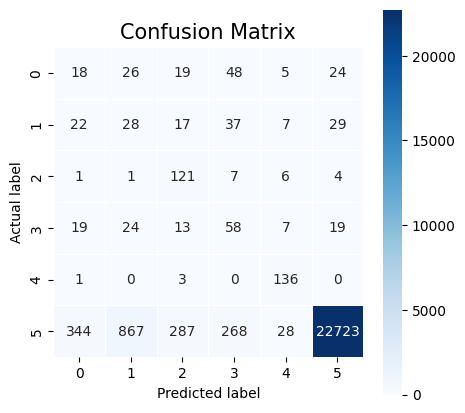

Epoch 73/100, Avg Val Loss: 0.0385, Val Accuracy: 0.9154


100%|██████████| 1/1 [00:00<00:00, 43.98it/s]


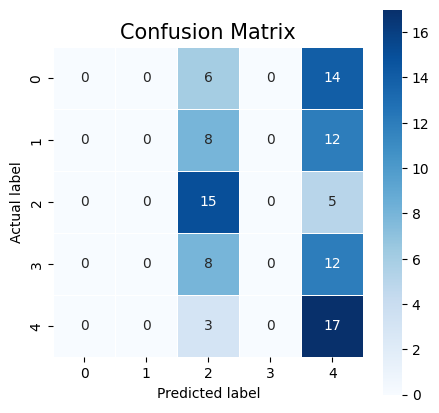

Epoch 73/100, Avg Val Loss: 1.8328, Val Accuracy: 0.3200
Epoch 73/100, Total Avg Val Loss: 0.9356, Total Avg Val Accuracy: 0.9131
Save new model at avg_val_loss: 0.9356


100%|██████████| 2/2 [00:00<00:00, 13.41it/s]


Epoch 74/100, Train Loss: 1.9819


100%|██████████| 99/99 [00:02<00:00, 34.41it/s]


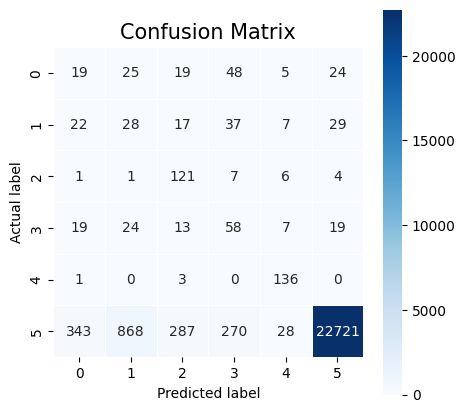

Epoch 74/100, Avg Val Loss: 0.0386, Val Accuracy: 0.9154


100%|██████████| 1/1 [00:00<00:00, 44.03it/s]


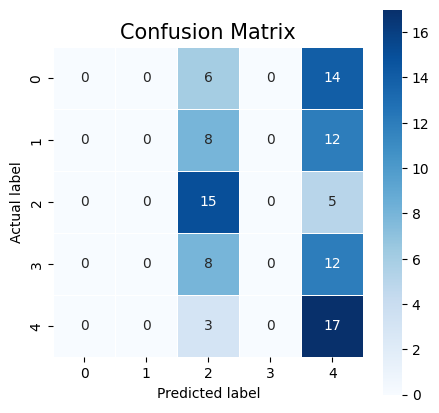

Epoch 74/100, Avg Val Loss: 1.8322, Val Accuracy: 0.3200
Epoch 74/100, Total Avg Val Loss: 0.9354, Total Avg Val Accuracy: 0.9130
Save new model at avg_val_loss: 0.9354


100%|██████████| 2/2 [00:00<00:00, 13.89it/s]


Epoch 75/100, Train Loss: 1.9828


100%|██████████| 99/99 [00:02<00:00, 33.60it/s]


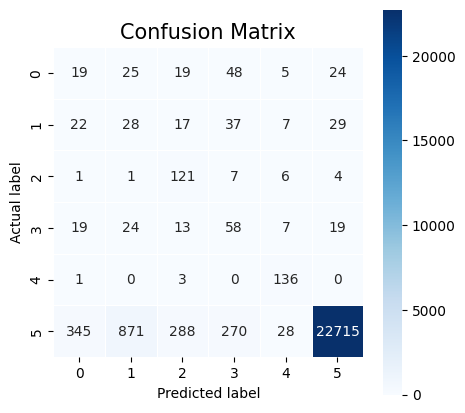

Epoch 75/100, Avg Val Loss: 0.0387, Val Accuracy: 0.9151


100%|██████████| 1/1 [00:00<00:00, 43.06it/s]


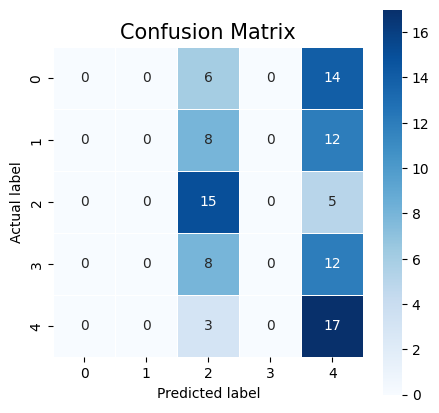

Epoch 75/100, Avg Val Loss: 1.8316, Val Accuracy: 0.3200
Epoch 75/100, Total Avg Val Loss: 0.9352, Total Avg Val Accuracy: 0.9128
Save new model at avg_val_loss: 0.9352


100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 76/100, Train Loss: 1.9745


100%|██████████| 99/99 [00:02<00:00, 33.80it/s]


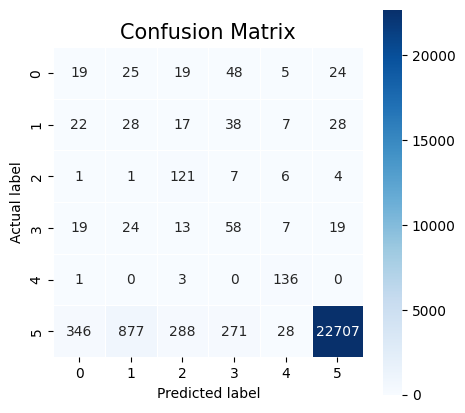

Epoch 76/100, Avg Val Loss: 0.0388, Val Accuracy: 0.9148


100%|██████████| 1/1 [00:00<00:00, 42.13it/s]


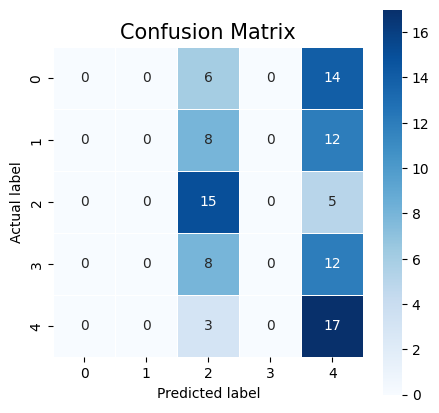

Epoch 76/100, Avg Val Loss: 1.8311, Val Accuracy: 0.3200
Epoch 76/100, Total Avg Val Loss: 0.9349, Total Avg Val Accuracy: 0.9125
Save new model at avg_val_loss: 0.9349


100%|██████████| 2/2 [00:00<00:00, 14.02it/s]


Epoch 77/100, Train Loss: 1.9772


100%|██████████| 99/99 [00:02<00:00, 34.46it/s]


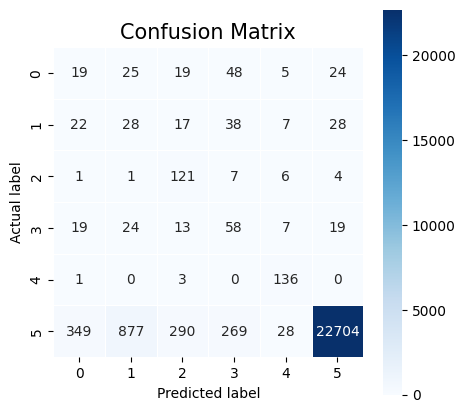

Epoch 77/100, Avg Val Loss: 0.0388, Val Accuracy: 0.9147


100%|██████████| 1/1 [00:00<00:00, 36.92it/s]


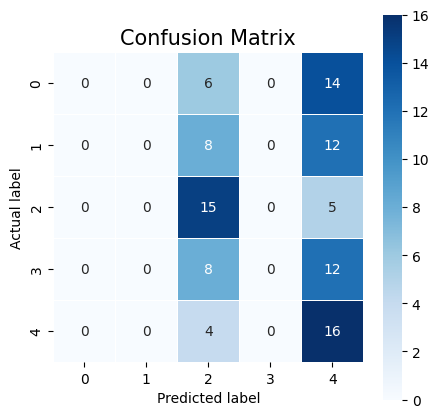

Epoch 77/100, Avg Val Loss: 1.8306, Val Accuracy: 0.3100
Epoch 77/100, Total Avg Val Loss: 0.9347, Total Avg Val Accuracy: 0.9123
Save new model at avg_val_loss: 0.9347


100%|██████████| 2/2 [00:00<00:00, 14.04it/s]


Epoch 78/100, Train Loss: 1.9755


100%|██████████| 99/99 [00:02<00:00, 34.21it/s]


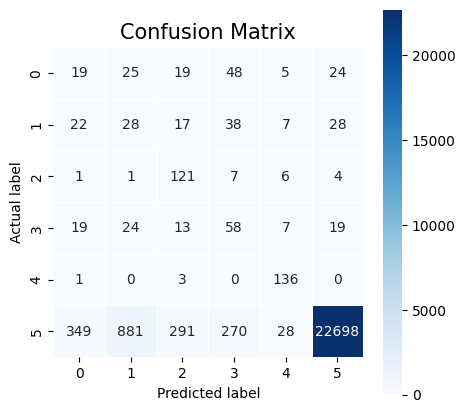

Epoch 78/100, Avg Val Loss: 0.0389, Val Accuracy: 0.9145


100%|██████████| 1/1 [00:00<00:00, 43.24it/s]


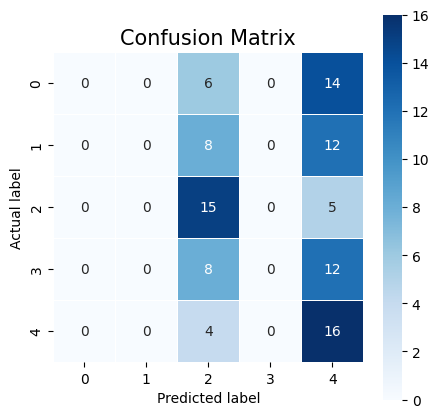

Epoch 78/100, Avg Val Loss: 1.8301, Val Accuracy: 0.3100
Epoch 78/100, Total Avg Val Loss: 0.9345, Total Avg Val Accuracy: 0.9121
Save new model at avg_val_loss: 0.9345


100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Epoch 79/100, Train Loss: 1.9675


100%|██████████| 99/99 [00:02<00:00, 34.42it/s]


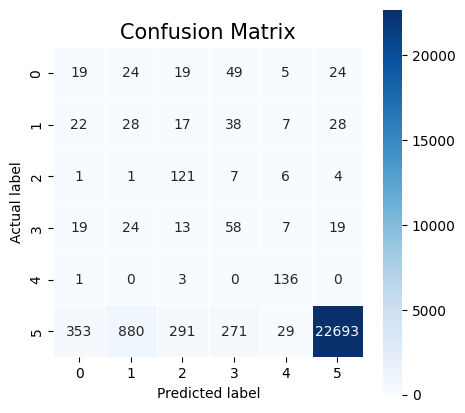

Epoch 79/100, Avg Val Loss: 0.0390, Val Accuracy: 0.9143


100%|██████████| 1/1 [00:00<00:00, 31.75it/s]


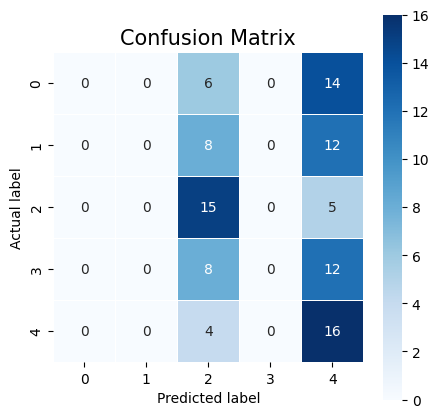

Epoch 79/100, Avg Val Loss: 1.8296, Val Accuracy: 0.3100
Epoch 79/100, Total Avg Val Loss: 0.9343, Total Avg Val Accuracy: 0.9119
Save new model at avg_val_loss: 0.9343


100%|██████████| 2/2 [00:00<00:00, 14.01it/s]


Epoch 80/100, Train Loss: 2.0014


100%|██████████| 99/99 [00:02<00:00, 33.79it/s]


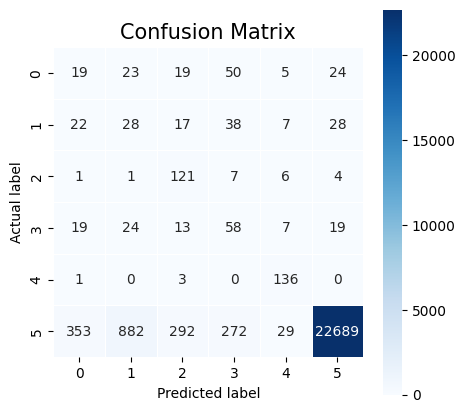

Epoch 80/100, Avg Val Loss: 0.0391, Val Accuracy: 0.9141


100%|██████████| 1/1 [00:00<00:00, 43.40it/s]


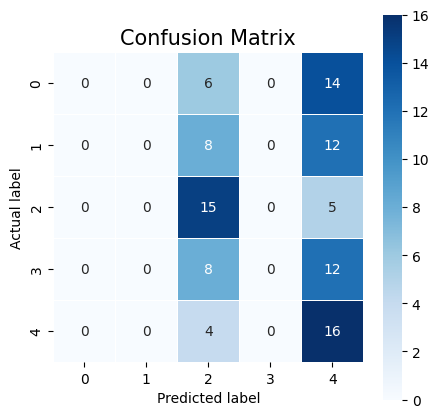

Epoch 80/100, Avg Val Loss: 1.8291, Val Accuracy: 0.3100
Epoch 80/100, Total Avg Val Loss: 0.9341, Total Avg Val Accuracy: 0.9117
Save new model at avg_val_loss: 0.9341


100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 81/100, Train Loss: 1.9976


100%|██████████| 99/99 [00:02<00:00, 33.63it/s]


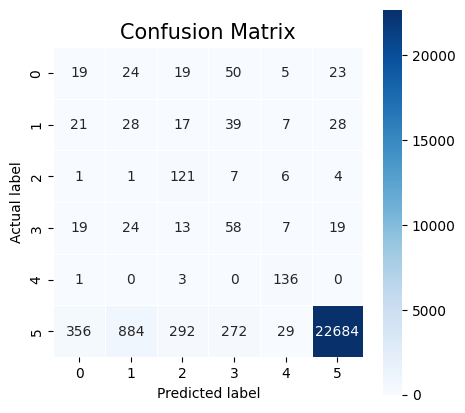

Epoch 81/100, Avg Val Loss: 0.0391, Val Accuracy: 0.9139


100%|██████████| 1/1 [00:00<00:00, 41.15it/s]


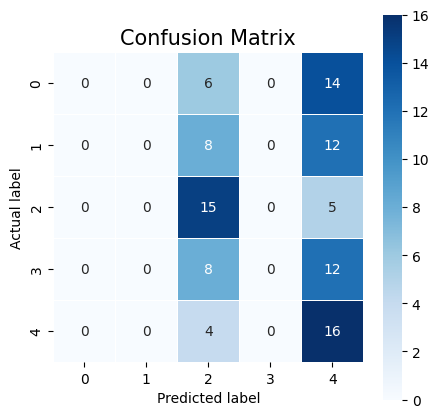

Epoch 81/100, Avg Val Loss: 1.8287, Val Accuracy: 0.3100
Epoch 81/100, Total Avg Val Loss: 0.9339, Total Avg Val Accuracy: 0.9115
Save new model at avg_val_loss: 0.9339


100%|██████████| 2/2 [00:00<00:00, 13.58it/s]


Epoch 82/100, Train Loss: 1.9836


100%|██████████| 99/99 [00:02<00:00, 34.30it/s]


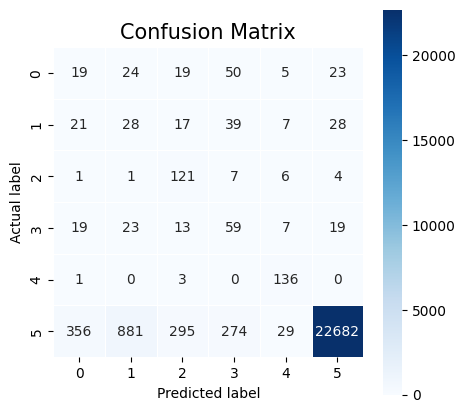

Epoch 82/100, Avg Val Loss: 0.0392, Val Accuracy: 0.9139


100%|██████████| 1/1 [00:00<00:00, 43.02it/s]


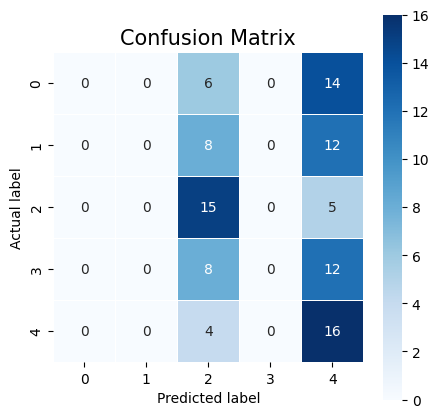

Epoch 82/100, Avg Val Loss: 1.8282, Val Accuracy: 0.3100
Epoch 82/100, Total Avg Val Loss: 0.9337, Total Avg Val Accuracy: 0.9115
Save new model at avg_val_loss: 0.9337


100%|██████████| 2/2 [00:00<00:00, 13.99it/s]


Epoch 83/100, Train Loss: 1.9683


100%|██████████| 99/99 [00:02<00:00, 34.09it/s]


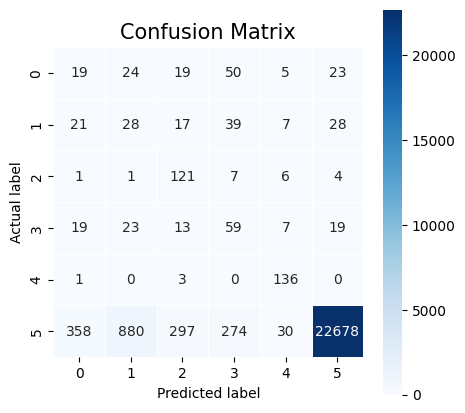

Epoch 83/100, Avg Val Loss: 0.0393, Val Accuracy: 0.9137


100%|██████████| 1/1 [00:00<00:00, 43.39it/s]


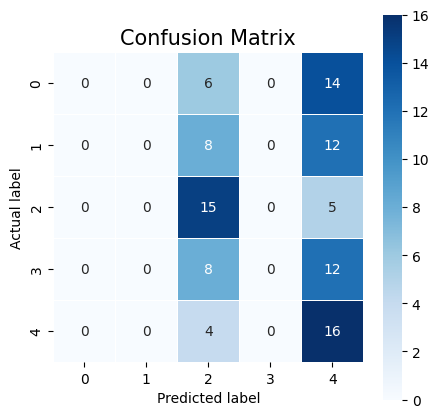

Epoch 83/100, Avg Val Loss: 1.8278, Val Accuracy: 0.3100
Epoch 83/100, Total Avg Val Loss: 0.9335, Total Avg Val Accuracy: 0.9113
Save new model at avg_val_loss: 0.9335


100%|██████████| 2/2 [00:00<00:00, 14.41it/s]


Epoch 84/100, Train Loss: 1.9439


100%|██████████| 99/99 [00:02<00:00, 34.21it/s]


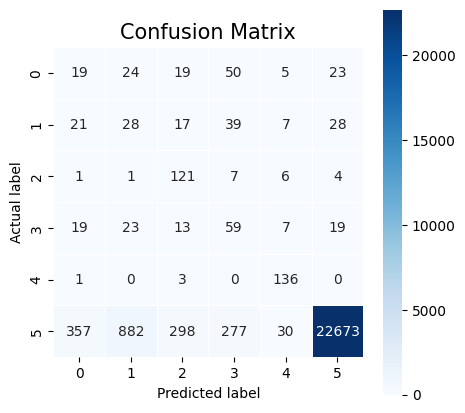

Epoch 84/100, Avg Val Loss: 0.0393, Val Accuracy: 0.9135


100%|██████████| 1/1 [00:00<00:00, 43.00it/s]


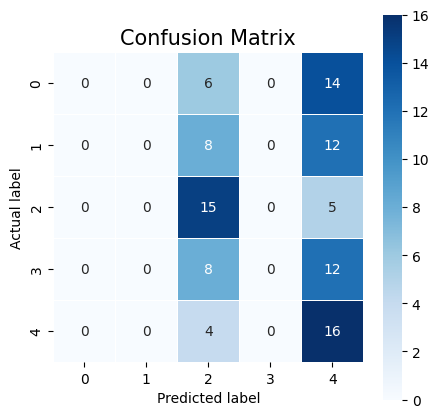

Epoch 84/100, Avg Val Loss: 1.8273, Val Accuracy: 0.3100
Epoch 84/100, Total Avg Val Loss: 0.9333, Total Avg Val Accuracy: 0.9111
Save new model at avg_val_loss: 0.9333


100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


Epoch 85/100, Train Loss: 1.9807


100%|██████████| 99/99 [00:02<00:00, 33.89it/s]


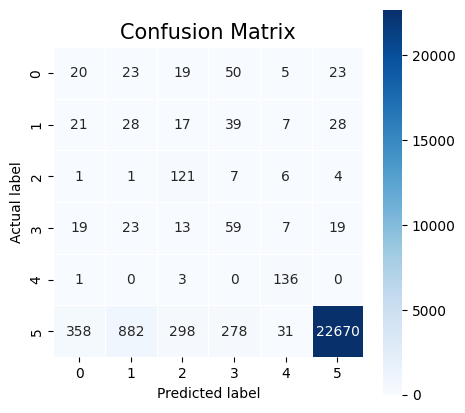

Epoch 85/100, Avg Val Loss: 0.0394, Val Accuracy: 0.9134


100%|██████████| 1/1 [00:00<00:00, 42.24it/s]


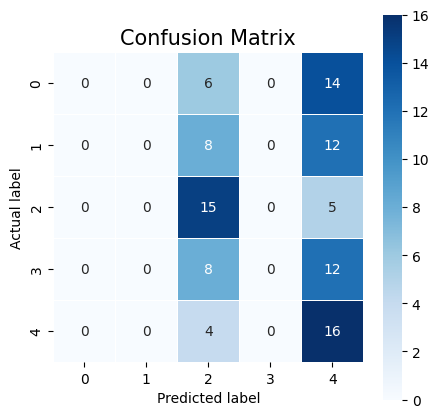

Epoch 85/100, Avg Val Loss: 1.8269, Val Accuracy: 0.3100
Epoch 85/100, Total Avg Val Loss: 0.9332, Total Avg Val Accuracy: 0.9110
Save new model at avg_val_loss: 0.9332


100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 86/100, Train Loss: 1.9573


100%|██████████| 99/99 [00:02<00:00, 33.27it/s]


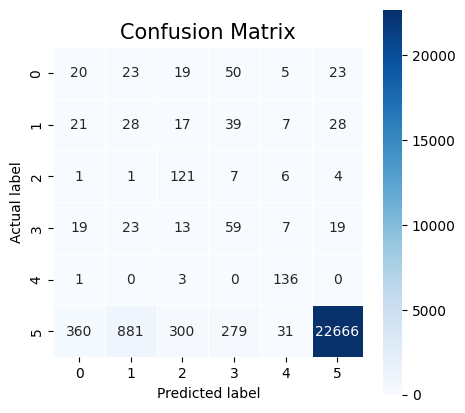

Epoch 86/100, Avg Val Loss: 0.0395, Val Accuracy: 0.9133


100%|██████████| 1/1 [00:00<00:00, 41.05it/s]


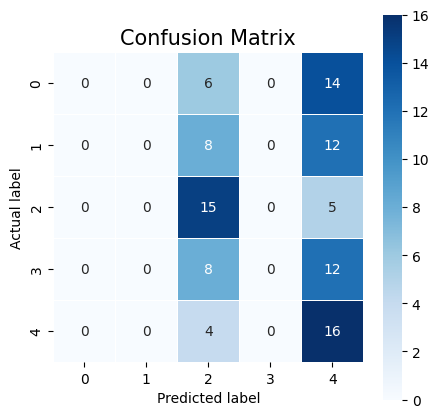

Epoch 86/100, Avg Val Loss: 1.8265, Val Accuracy: 0.3100
Epoch 86/100, Total Avg Val Loss: 0.9330, Total Avg Val Accuracy: 0.9109
Save new model at avg_val_loss: 0.9330


100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


Epoch 87/100, Train Loss: 1.9649


100%|██████████| 99/99 [00:02<00:00, 33.94it/s]


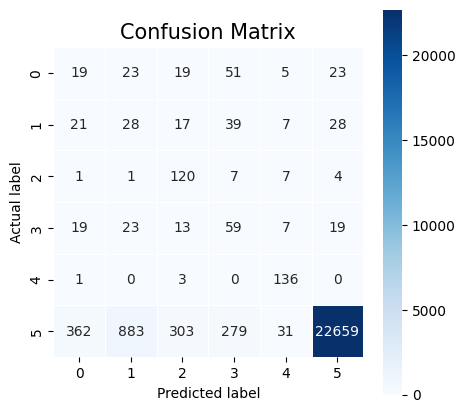

Epoch 87/100, Avg Val Loss: 0.0395, Val Accuracy: 0.9129


100%|██████████| 1/1 [00:00<00:00, 44.07it/s]


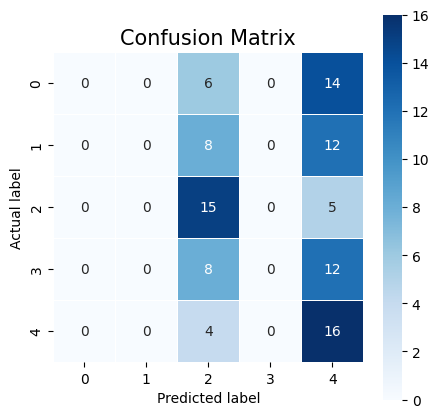

Epoch 87/100, Avg Val Loss: 1.8261, Val Accuracy: 0.3100
Epoch 87/100, Total Avg Val Loss: 0.9328, Total Avg Val Accuracy: 0.9105
Save new model at avg_val_loss: 0.9328


100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Epoch 88/100, Train Loss: 1.9709


100%|██████████| 99/99 [00:02<00:00, 34.24it/s]


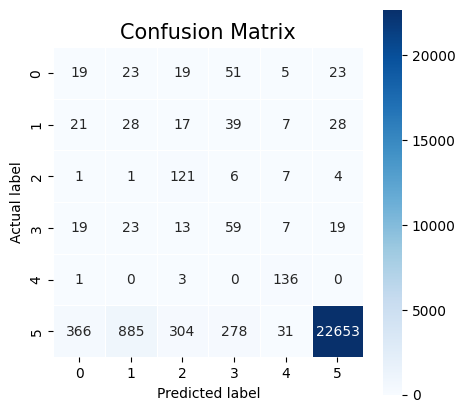

Epoch 88/100, Avg Val Loss: 0.0396, Val Accuracy: 0.9127


100%|██████████| 1/1 [00:00<00:00, 42.45it/s]


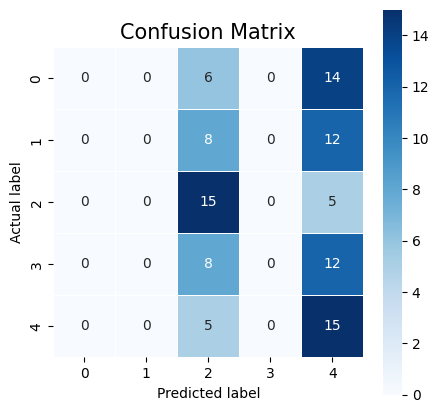

Epoch 88/100, Avg Val Loss: 1.8258, Val Accuracy: 0.3000
Epoch 88/100, Total Avg Val Loss: 0.9327, Total Avg Val Accuracy: 0.9103
Save new model at avg_val_loss: 0.9327


100%|██████████| 2/2 [00:00<00:00, 13.88it/s]


Epoch 89/100, Train Loss: 1.9832


100%|██████████| 99/99 [00:02<00:00, 33.83it/s]


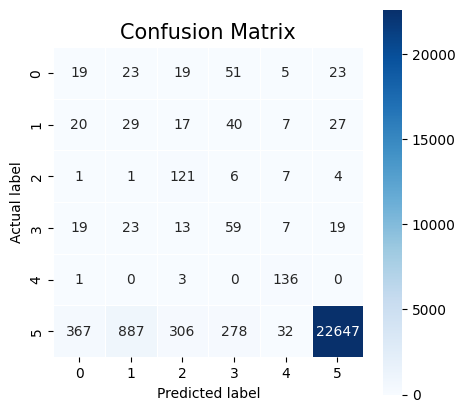

Epoch 89/100, Avg Val Loss: 0.0397, Val Accuracy: 0.9125


100%|██████████| 1/1 [00:00<00:00, 44.24it/s]


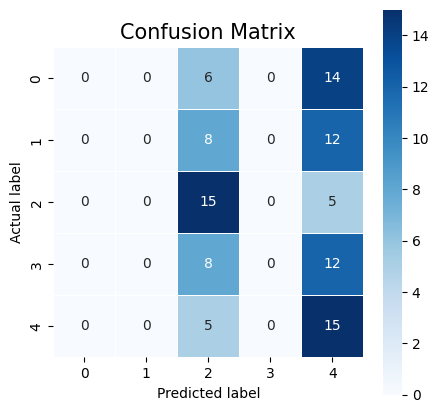

Epoch 89/100, Avg Val Loss: 1.8254, Val Accuracy: 0.3000
Epoch 89/100, Total Avg Val Loss: 0.9325, Total Avg Val Accuracy: 0.9101
Save new model at avg_val_loss: 0.9325


100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 90/100, Train Loss: 1.9877


100%|██████████| 99/99 [00:02<00:00, 34.27it/s]


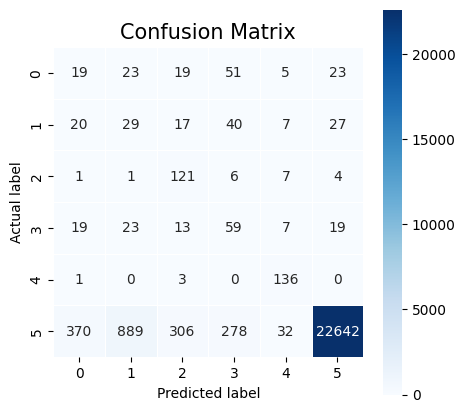

Epoch 90/100, Avg Val Loss: 0.0397, Val Accuracy: 0.9123


100%|██████████| 1/1 [00:00<00:00, 42.63it/s]


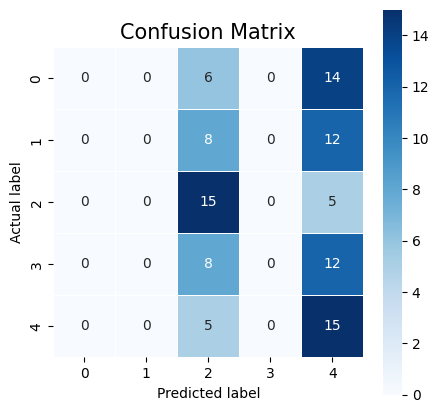

Epoch 90/100, Avg Val Loss: 1.8250, Val Accuracy: 0.3000
Epoch 90/100, Total Avg Val Loss: 0.9324, Total Avg Val Accuracy: 0.9099
Save new model at avg_val_loss: 0.9324


100%|██████████| 2/2 [00:00<00:00, 14.00it/s]


Epoch 91/100, Train Loss: 1.9599


100%|██████████| 99/99 [00:02<00:00, 33.35it/s]


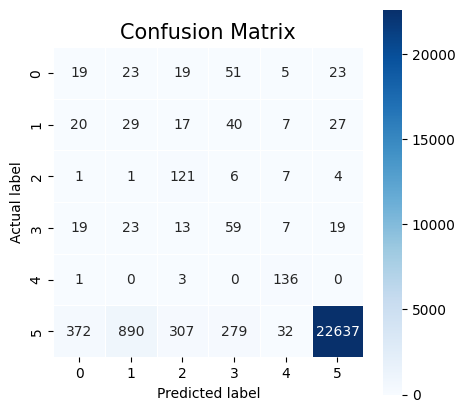

Epoch 91/100, Avg Val Loss: 0.0398, Val Accuracy: 0.9121


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


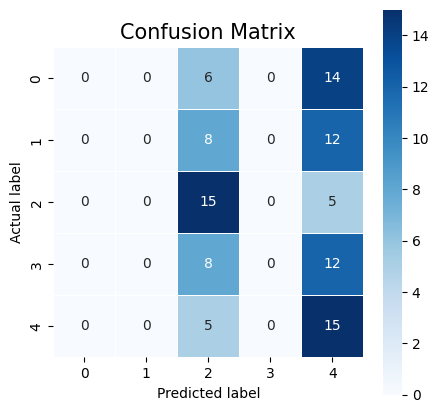

Epoch 91/100, Avg Val Loss: 1.8246, Val Accuracy: 0.3000
Epoch 91/100, Total Avg Val Loss: 0.9322, Total Avg Val Accuracy: 0.9097
Save new model at avg_val_loss: 0.9322


100%|██████████| 2/2 [00:00<00:00, 13.73it/s]


Epoch 92/100, Train Loss: 1.9535


100%|██████████| 99/99 [00:02<00:00, 34.26it/s]


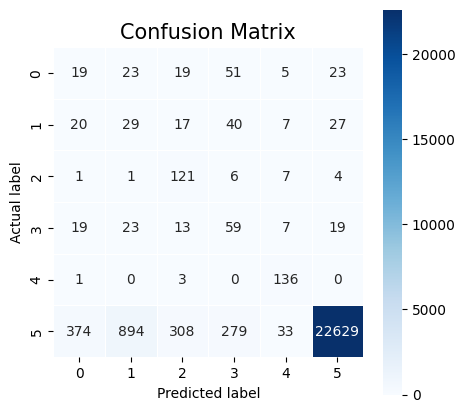

Epoch 92/100, Avg Val Loss: 0.0398, Val Accuracy: 0.9118


100%|██████████| 1/1 [00:00<00:00, 44.49it/s]


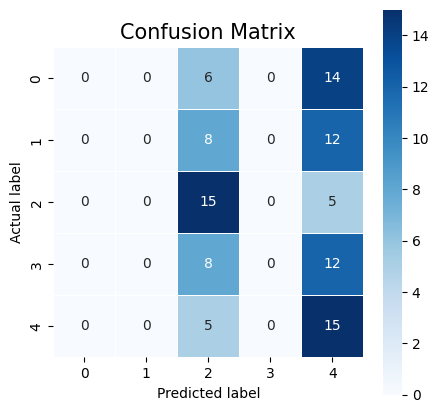

Epoch 92/100, Avg Val Loss: 1.8243, Val Accuracy: 0.3000
Epoch 92/100, Total Avg Val Loss: 0.9321, Total Avg Val Accuracy: 0.9094
Save new model at avg_val_loss: 0.9321


100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


Epoch 93/100, Train Loss: 1.9900


100%|██████████| 99/99 [00:02<00:00, 34.22it/s]


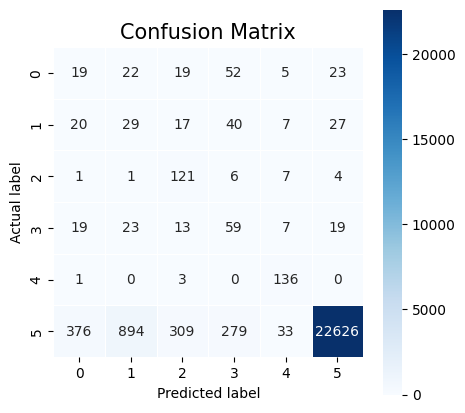

Epoch 93/100, Avg Val Loss: 0.0399, Val Accuracy: 0.9117


100%|██████████| 1/1 [00:00<00:00, 41.62it/s]


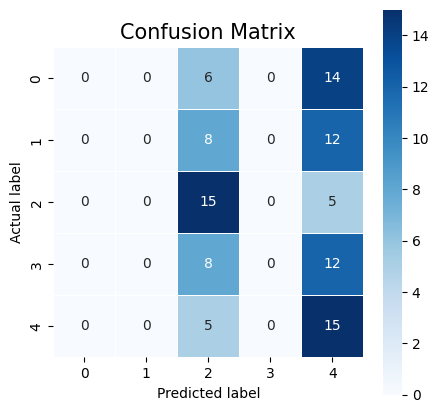

Epoch 93/100, Avg Val Loss: 1.8239, Val Accuracy: 0.3000
Epoch 93/100, Total Avg Val Loss: 0.9319, Total Avg Val Accuracy: 0.9093
Save new model at avg_val_loss: 0.9319


100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Epoch 94/100, Train Loss: 1.9759


100%|██████████| 99/99 [00:02<00:00, 33.81it/s]


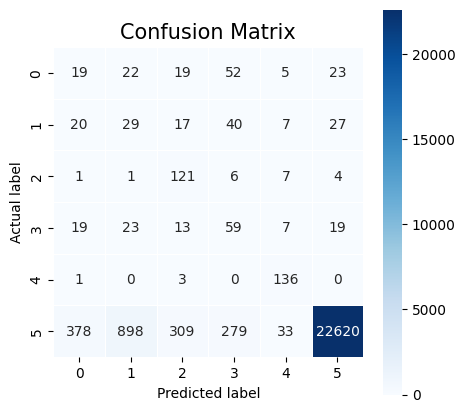

Epoch 94/100, Avg Val Loss: 0.0400, Val Accuracy: 0.9114


100%|██████████| 1/1 [00:00<00:00, 42.49it/s]


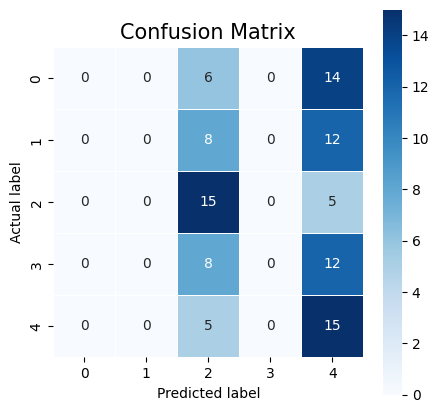

Epoch 94/100, Avg Val Loss: 1.8236, Val Accuracy: 0.3000
Epoch 94/100, Total Avg Val Loss: 0.9318, Total Avg Val Accuracy: 0.9090
Save new model at avg_val_loss: 0.9318


100%|██████████| 2/2 [00:00<00:00, 13.92it/s]


Epoch 95/100, Train Loss: 1.9448


100%|██████████| 99/99 [00:02<00:00, 34.33it/s]


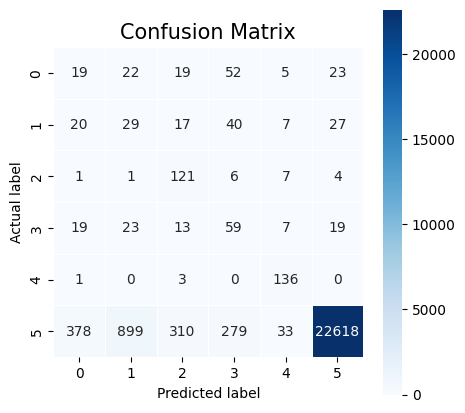

Epoch 95/100, Avg Val Loss: 0.0400, Val Accuracy: 0.9114


100%|██████████| 1/1 [00:00<00:00, 40.31it/s]


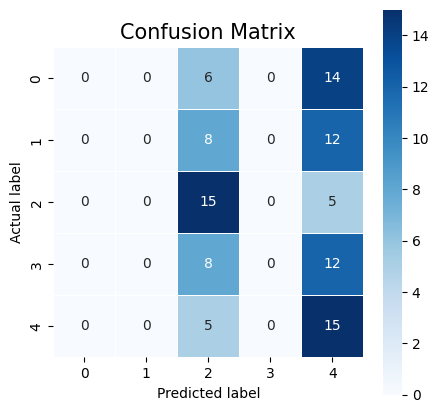

Epoch 95/100, Avg Val Loss: 1.8233, Val Accuracy: 0.3000
Epoch 95/100, Total Avg Val Loss: 0.9316, Total Avg Val Accuracy: 0.9090
Save new model at avg_val_loss: 0.9316


100%|██████████| 2/2 [00:00<00:00, 13.83it/s]


Epoch 96/100, Train Loss: 1.9502


100%|██████████| 99/99 [00:02<00:00, 33.53it/s]


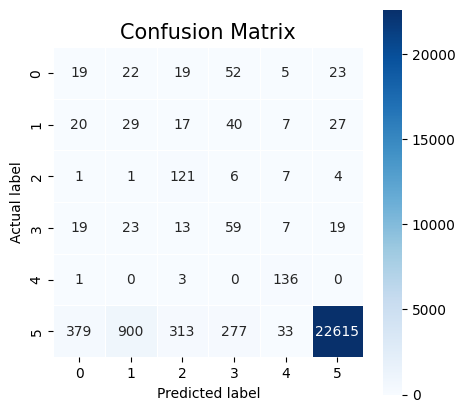

Epoch 96/100, Avg Val Loss: 0.0401, Val Accuracy: 0.9113


100%|██████████| 1/1 [00:00<00:00, 42.18it/s]


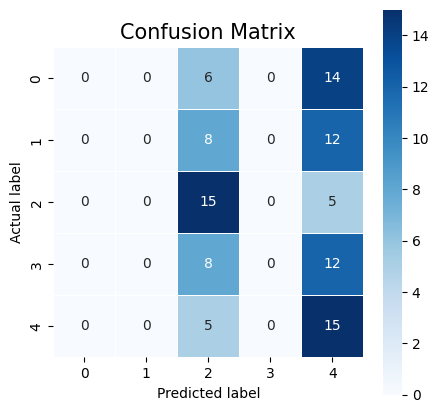

Epoch 96/100, Avg Val Loss: 1.8230, Val Accuracy: 0.3000
Epoch 96/100, Total Avg Val Loss: 0.9315, Total Avg Val Accuracy: 0.9088
Save new model at avg_val_loss: 0.9315


100%|██████████| 2/2 [00:00<00:00, 13.96it/s]


Epoch 97/100, Train Loss: 1.9757


100%|██████████| 99/99 [00:02<00:00, 33.76it/s]


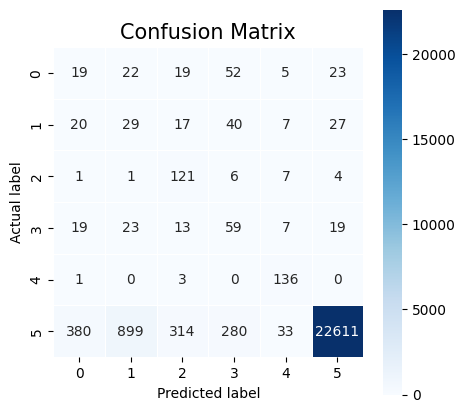

Epoch 97/100, Avg Val Loss: 0.0401, Val Accuracy: 0.9111


100%|██████████| 1/1 [00:00<00:00, 42.93it/s]


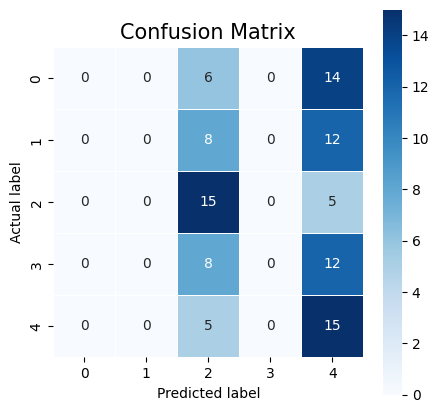

Epoch 97/100, Avg Val Loss: 1.8226, Val Accuracy: 0.3000
Epoch 97/100, Total Avg Val Loss: 0.9314, Total Avg Val Accuracy: 0.9087
Save new model at avg_val_loss: 0.9314


100%|██████████| 2/2 [00:00<00:00, 14.13it/s]


Epoch 98/100, Train Loss: 1.9684


100%|██████████| 99/99 [00:02<00:00, 34.32it/s]


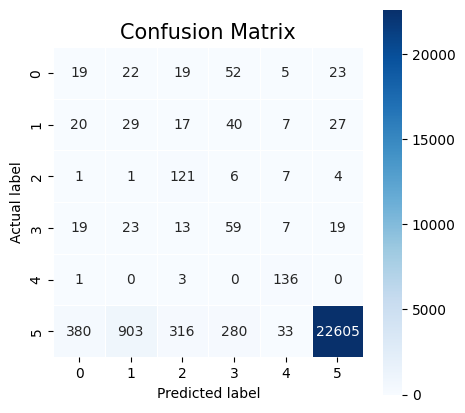

Epoch 98/100, Avg Val Loss: 0.0402, Val Accuracy: 0.9109


100%|██████████| 1/1 [00:00<00:00, 43.73it/s]


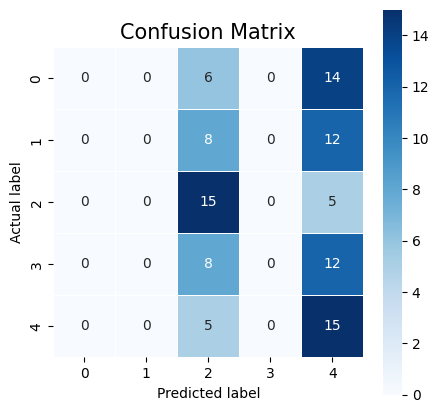

Epoch 98/100, Avg Val Loss: 1.8223, Val Accuracy: 0.3000
Epoch 98/100, Total Avg Val Loss: 0.9313, Total Avg Val Accuracy: 0.9084
Save new model at avg_val_loss: 0.9313


100%|██████████| 2/2 [00:00<00:00, 12.11it/s]


Epoch 99/100, Train Loss: 1.9408


100%|██████████| 99/99 [00:02<00:00, 33.66it/s]


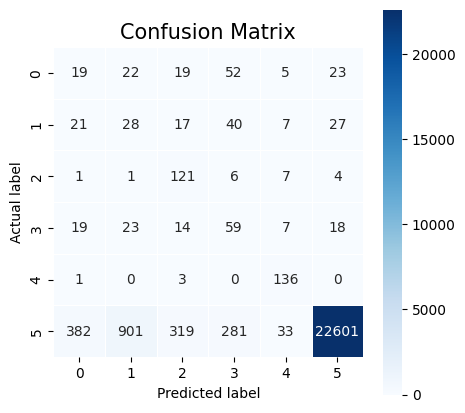

Epoch 99/100, Avg Val Loss: 0.0403, Val Accuracy: 0.9107


100%|██████████| 1/1 [00:00<00:00, 42.30it/s]


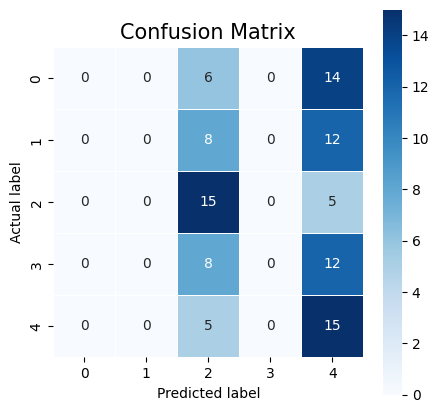

Epoch 99/100, Avg Val Loss: 1.8220, Val Accuracy: 0.3000
Epoch 99/100, Total Avg Val Loss: 0.9311, Total Avg Val Accuracy: 0.9082
Save new model at avg_val_loss: 0.9311


100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


Epoch 100/100, Train Loss: 1.9329


100%|██████████| 99/99 [00:02<00:00, 33.86it/s]


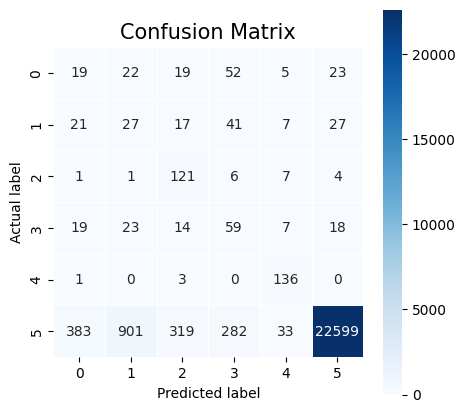

Epoch 100/100, Avg Val Loss: 0.0403, Val Accuracy: 0.9105


100%|██████████| 1/1 [00:00<00:00, 42.44it/s]


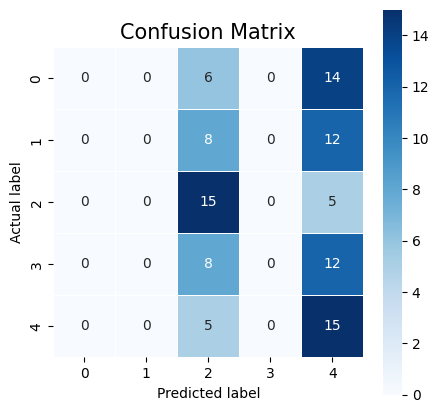

Epoch 100/100, Avg Val Loss: 1.8217, Val Accuracy: 0.3000
Epoch 100/100, Total Avg Val Loss: 0.9310, Total Avg Val Accuracy: 0.9081
Save new model at avg_val_loss: 0.9310


In [ ]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        if alpha is not None:
            if isinstance(alpha, (list, tuple)):
                self.alpha = torch.tensor(alpha).to(device)  # Move alpha to GPU
            else:
                self.alpha = alpha.to(device)  # Move alpha to GPU
        else:
            self.alpha = None
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')  # Changed line
        pt = torch.exp(-ce_loss)
        if self.alpha is not None:
            at = self.alpha[targets.data.view(-1)].to(inputs.device)
            logpt = - ce_loss
            pt = torch.exp(logpt)
            F_loss = -at * (1-pt)**self.gamma * logpt
        else:
            F_loss = - (1-pt)**self.gamma * ce_loss

        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()


def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title('Confusion Matrix', size = 15);
    plt.show()

def train_epoch(model, criterion_machine_id, optimizer, data_loader, device):
    model.train()
    train_loss = 0.0
    for data, machine_id_labels in tqdm(data_loader):
        data, machine_id_labels = data.to(device).long(), machine_id_labels.to(device).long()
        optimizer.zero_grad()
        machine_id_outputs = model(data)
        machine_id_loss = criterion_machine_id(machine_id_outputs, machine_id_labels)
        loss = machine_id_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(data_loader)

def validate_epoch(model, criterion_machine_id, data_loader, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data, machine_id_labels in tqdm(data_loader):
            data, machine_id_labels = data.to(device).long(), machine_id_labels.to(device).long()
            machine_id_outputs = model(data)
            machine_id_loss = criterion_machine_id(machine_id_outputs, machine_id_labels)
            loss = machine_id_loss
            val_loss += loss.item()
            _, predicted = torch.max(machine_id_outputs.data, 1)
            total += machine_id_labels.size(0)
            correct += (predicted == machine_id_labels).sum().item()
            all_labels.extend(machine_id_labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    return val_loss / len(data_loader), correct / total, all_labels, all_predictions

def train_model(model, source_train_loader, source_val_loader, target_train_loader, target_val_loader, num_epochs, pretrain_learning_rate, fine_tune_learning_rate):
    #os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    model = model.to(device)
    pretrain_alpha_machine_id = torch.tensor([122000/125000, 122000/125000, 122000/125000, 122000/125000, 122000/125000, 3000/125000]).to(device)
    fine_tune_alpha_machine_id = torch.tensor([700/800, 700/800, 700/800, 700/800, 0, 100/800]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=pretrain_learning_rate)
    criterion_machine_id = FocalLoss(gamma=2.0, alpha=pretrain_alpha_machine_id, reduction='mean')
    best_avg_loss = float('inf')
    best_model = None
    first_finetuning_epoch = True
    for epoch in range(num_epochs):
        data_loader = source_train_loader if epoch < num_epochs // 2 else target_train_loader
        if epoch == num_epochs // 2:
            criterion_machine_id.alpha = fine_tune_alpha_machine_id
            for param_group in optimizer.param_groups:
                param_group['lr'] = fine_tune_learning_rate
        train_loss = train_epoch(model, criterion_machine_id, optimizer, data_loader, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
        total_val_loss = 0.0
        total_correct = 0
        total_samples = 0
        val_loaders = [source_val_loader] if epoch < num_epochs // 2 else [source_val_loader, target_val_loader]
        for val_loader in val_loaders:
            val_loss, val_accuracy, all_labels, all_predictions = validate_epoch(model, criterion_machine_id, val_loader, device)
            print_confusion_matrix(all_labels, all_predictions)
            total_val_loss += val_loss
            total_correct += val_accuracy * len(val_loader.dataset)
            total_samples += len(val_loader.dataset)
            print(f"Epoch {epoch+1}/{num_epochs}, Avg Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        avg_val_loss = total_val_loss / len(val_loaders)
        avg_val_accuracy = total_correct / total_samples
        print(f"Epoch {epoch+1}/{num_epochs}, Total Avg Val Loss: {avg_val_loss:.4f}, Total Avg Val Accuracy: {avg_val_accuracy:.4f}")
        if avg_val_loss < best_avg_loss or (epoch == (num_epochs // 2) and first_finetuning_epoch):
            best_avg_loss = avg_val_loss
            best_model = model.state_dict()
            if first_finetuning_epoch and epoch == (num_epochs // 2):
                print(f"Save the first fine-tuned model at avg_val_loss: {best_avg_loss:.4f}")
                first_finetuning_epoch = False
            else:
                print(f"Save new model at avg_val_loss: {best_avg_loss:.4f}")
    model.load_state_dict(best_model)
    return model

vocab_size = config.vocab_size
embedding_dim = config.embedding_dim
input_size = config.input_size
hidden_size = config.hidden_size
num_machine = config.num_machine
model = MultitaskGRUClassifier(input_size, hidden_size, num_machine,vocab_size, embedding_dim)

num_epochs = config.num_epochs
pretrain_learning_rate = config.pretrain_learning_rate
fine_tune_learning_rate = config.fine_tune_learning_rate

# Capture the best model state returned by train_model
model = train_model(model, source_train_loader, source_val_loader, target_train_loader, target_val_loader, num_epochs, pretrain_learning_rate,fine_tune_learning_rate)

In [ ]:
class TextpredDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        concat = self.dataframe.loc[idx, 'concat']
        return concat

In [ ]:
predict_x['concat'] = predict_x.apply(lambda x: combine_lists(x), axis=1)

In [ ]:
def preprocess_predfeatures(predict_x, max_len_concat):
    pred_concat = predict_x['concat'].apply(lambda x: torch.tensor(x, dtype=torch.long))

    # Pad the sequences to the specified max lengths
    pred_concat = pad_sequence(pred_concat, batch_first=True, padding_value=0).to(torch.long)

    # Truncate the sequences to the specified max lengths
    pred_concat = pred_concat[:, :max_len_concat]

    return pred_concat

In [ ]:
pred_concat = preprocess_predfeatures(predict_x, max_len_concat)
# Create a new DataFrame with preprocessed features and labels
preprocessed_predict_dataset = pd.DataFrame({'concat': list(pred_concat)})
print(preprocessed_predict_dataset.head())

                                              concat
0  [tensor(2109), tensor(2263), tensor(86), tenso...
1  [tensor(2267), tensor(1890), tensor(3460), ten...
2  [tensor(1602), tensor(2770), tensor(4021), ten...
3  [tensor(1939), tensor(2059), tensor(1628), ten...
4  [tensor(3101), tensor(1479), tensor(2564), ten...


In [ ]:
pred_dataset = TextpredDataset(preprocessed_predict_dataset)
pred_loader = DataLoader(pred_dataset)

In [ ]:
predict = []
with torch.no_grad():
    for concats in tqdm(pred_loader):
        # Move data to the device
        concats = concats.to(device).long()
        outputs = model(concats)
        _, predicted = torch.max(outputs.data, 1)
        # Map labels from 0-4 to 0, and 5 to 1
        predicted = (predicted == 5).long()  # if predicted equals 5, return 1, else return 0
        predict.append(predicted)

100%|██████████| 1000/1000 [00:18<00:00, 54.18it/s]


In [ ]:
indentity = []
for Id in range(0,1000):
    indentity.append(Id)
    predict[Id] = int(predict[Id])

In [ ]:
submission = pd.DataFrame({'Id':indentity,'Predicted': predict})

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
submission['Predicted'].value_counts()

1    539
0    461
Name: Predicted, dtype: int64

In [ ]:
submit = pd.read_csv('submission.csv')

In [ ]:
submit

Id  Predicted
0      0          0
1      1          0
2      2          0
3      3          0
4      4          0
..   ...        ...
995  995          1
996  996          1
997  997          0
998  998          0
999  999          1

[1000 rows x 2 columns]